# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Для достижения цели исследования разработан следующий план:
1. Произвести предобработку данных
2. Добавить вспомогательные столбцы с дополнительными расчетами
3. Проведение исследовательского анализа с промежуточными выводами
4. Общий вывод

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('./datasets/real_estate_data.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


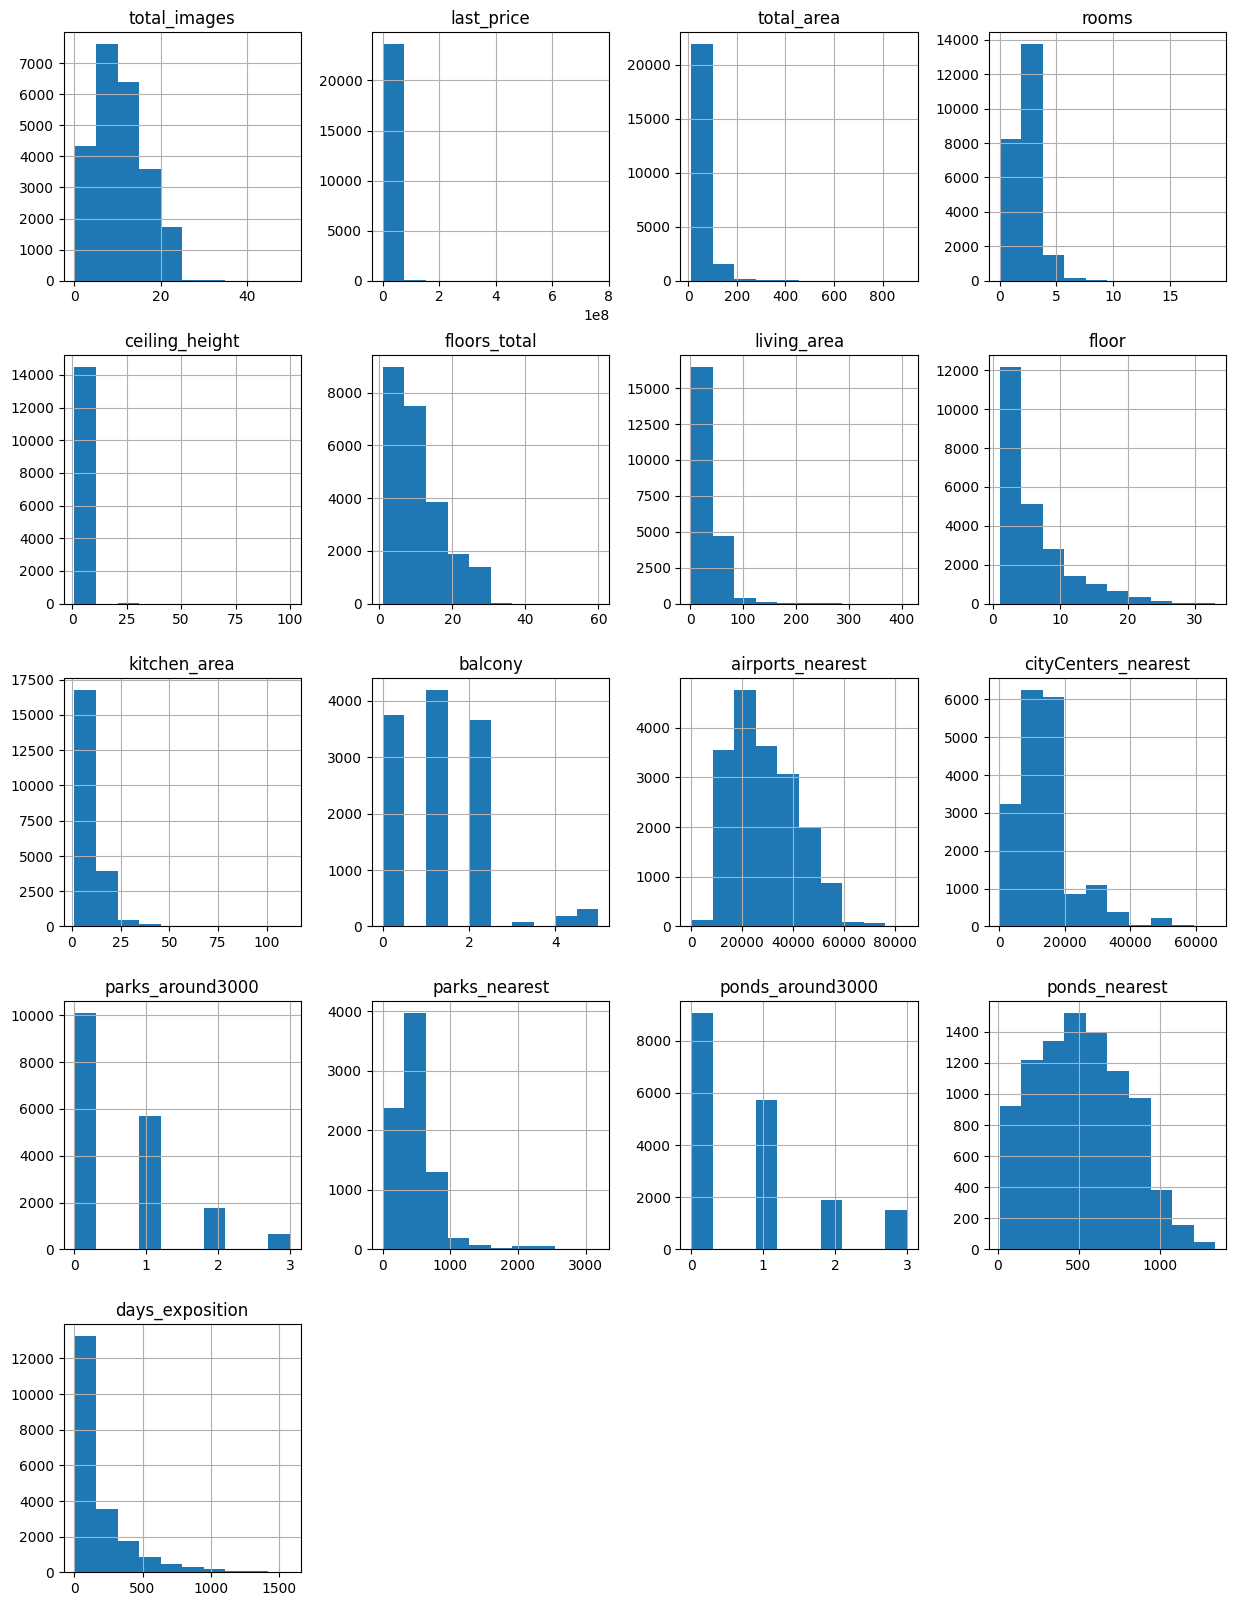

In [5]:
data.hist(figsize=(15, 20));

Диаграммы показывают, что некоторые данные очень искажены из-за большого количества выбросов.

### Предобработка данных

In [6]:
data.duplicated().sum() # поиск дубликатов

0

In [7]:
data.isna().sum() # пропущенные значения

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Обработка столбца `locality_name`

В столбце `locality_name` удалим неявные дубликаты, оставив только собственные имена населенных пунктов.

In [8]:
data['locality_name'].nunique() # кол-во уникальных имен

364

In [9]:
data['locality_name'].sort_values(ascending=False).unique()

array(['село Шум', 'село Старая Ладога', 'село Русско-Высоцкое',
       'село Рождествено', 'село Путилово', 'село Паша', 'село Павлово',
       'село Никольское', 'село Копорье', 'садовое товарищество Садко',
       'садовое товарищество Рахья', 'садовое товарищество Приладожский',
       'садовое товарищество Новая Ропша',
       'садоводческое некоммерческое товарищество Лесная Поляна',
       'посёлок станции Свирь', 'посёлок станции Громово',
       'посёлок при железнодорожной станции Приветнинское',
       'посёлок при железнодорожной станции Вещево',
       'посёлок городского типа имени Свердлова',
       'посёлок городского типа имени Морозова',
       'посёлок городского типа Форносово',
       'посёлок городского типа Ульяновка',
       'посёлок городского типа Токсово', 'посёлок городского типа Тайцы',
       'посёлок городского типа Сиверский',
       'посёлок городского типа Рябово', 'посёлок городского типа Рощино',
       'посёлок городского типа Павлово', 'посёлок гор

In [10]:
# сначала приведем все типы населенных пунктов к "посёлок"
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный посёлок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('деревня', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок станции', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок при железнодорожной станции', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'посёлок')
data['locality_name'] = data['locality_name'].str.replace('село','посёлок')
# заменим "посёлок" на пустой символ
data['locality_name'] = data['locality_name'].str.replace('посёлок ', '')

In [11]:
data['locality_name'].nunique() # стало уникальных имен

305

In [12]:
print(data['locality_name'].sort_values().unique())

['Агалатово' 'Александровская' 'Алексеевка' 'Аннино' 'Аро' 'Барышево'
 'Батово' 'Бегуницы' 'Белогорка' 'Белоостров' 'Бокситогорск'
 'Большая Вруда' 'Большая Ижора' 'Большая Пустомержа' 'Большие Колпаны'
 'Большое Рейзино' 'Большой Сабск' 'Бор' 'Борисова Грива' 'Бугры'
 'Будогощь' 'Ваганово' 'Важины' 'Вартемяги' 'Вахнова Кара' 'Вещево'
 'Виллози' 'Вознесенье' 'Возрождение' 'Войсковицы' 'Войскорово'
 'Володарское' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Вырица'
 'Выскатка' 'Высокоключевой' 'Высоцк' 'Гаврилово' 'Гарболово' 'Гатчина'
 'Гладкое' 'Глажево' 'Глебычево' 'Глинка' 'Гончарово' 'Горбунки'
 'Гостилицы' 'Громово' 'Дзержинского' 'Дружная Горка' 'Дружноселье'
 'Дубровка' 'Елизаветино' 'Ефимовский' 'Жилгородок' 'Жилпосёлок' 'Житково'
 'Заводской' 'Заклинье' 'Заневка' 'Запорожское' 'Зеленогорск' 'Зимитицы'
 'Ивангород' 'Извара' 'Ильичёво' 'Иссад' 'Калитино' 'Каложицы' 'Кальтино'
 'Каменногорск' 'Камышовка' 'Каськово' 'Келози' 'Кивеннапа Север'
 'Кикерино' 'Кингисепп' 'Кингисеппский' 

In [13]:
 # пропущенные значения заполним 'Неизвестно'
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

#### Обработка столбца `ceiling_height`

Отсортируем столбец `ceiling_height` по убыванию. Исправим типичные опечатки, например 27 вместо 2.7, и заполним отсутствующие значения на медианное значение высоты потолков.

In [14]:
data['ceiling_height'].sort_values(ascending=False).unique()

array([100.  ,  32.  ,  27.5 ,  27.  ,  26.  ,  25.  ,  24.  ,  22.6 ,
        20.  ,  14.  ,  10.3 ,   8.3 ,   8.  ,   6.  ,   5.8 ,   5.6 ,
         5.5 ,   5.3 ,   5.2 ,   5.  ,   4.9 ,   4.8 ,   4.7 ,   4.65,
         4.5 ,   4.45,   4.4 ,   4.37,   4.3 ,   4.25,   4.2 ,   4.19,
         4.15,   4.14,   4.1 ,   4.06,   4.  ,   3.98,   3.95,   3.93,
         3.9 ,   3.88,   3.87,   3.86,   3.85,   3.84,   3.83,   3.82,
         3.8 ,   3.78,   3.76,   3.75,   3.7 ,   3.69,   3.68,   3.67,
         3.66,   3.65,   3.63,   3.62,   3.6 ,   3.59,   3.58,   3.57,
         3.56,   3.55,   3.54,   3.53,   3.52,   3.51,   3.5 ,   3.49,
         3.48,   3.47,   3.46,   3.45,   3.44,   3.43,   3.42,   3.4 ,
         3.39,   3.38,   3.37,   3.36,   3.35,   3.34,   3.33,   3.32,
         3.31,   3.3 ,   3.29,   3.28,   3.27,   3.26,   3.25,   3.24,
         3.23,   3.22,   3.21,   3.2 ,   3.18,   3.17,   3.16,   3.15,
         3.14,   3.13,   3.12,   3.11,   3.1 ,   3.09,   3.08,   3.07,
      

In [15]:
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] = \
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] / 10  # заменяем явные опечатки
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) # заполняем NAN медианой 2.65

In [16]:
data['ceiling_height'].sort_values(ascending=False).unique() # еще раз проверяем значения

array([24.  , 22.6 , 20.  , 14.  , 10.3 , 10.  ,  8.3 ,  8.  ,  6.  ,
        5.8 ,  5.6 ,  5.5 ,  5.3 ,  5.2 ,  5.  ,  4.9 ,  4.8 ,  4.7 ,
        4.65,  4.5 ,  4.45,  4.4 ,  4.37,  4.3 ,  4.25,  4.2 ,  4.19,
        4.15,  4.14,  4.1 ,  4.06,  4.  ,  3.98,  3.95,  3.93,  3.9 ,
        3.88,  3.87,  3.86,  3.85,  3.84,  3.83,  3.82,  3.8 ,  3.78,
        3.76,  3.75,  3.7 ,  3.69,  3.68,  3.67,  3.66,  3.65,  3.63,
        3.62,  3.6 ,  3.59,  3.58,  3.57,  3.56,  3.55,  3.54,  3.53,
        3.52,  3.51,  3.5 ,  3.49,  3.48,  3.47,  3.46,  3.45,  3.44,
        3.43,  3.42,  3.4 ,  3.39,  3.38,  3.37,  3.36,  3.35,  3.34,
        3.33,  3.32,  3.31,  3.3 ,  3.29,  3.28,  3.27,  3.26,  3.25,
        3.24,  3.23,  3.22,  3.21,  3.2 ,  3.18,  3.17,  3.16,  3.15,
        3.14,  3.13,  3.12,  3.11,  3.1 ,  3.09,  3.08,  3.07,  3.06,
        3.05,  3.04,  3.03,  3.02,  3.01,  3.  ,  2.99,  2.98,  2.97,
        2.96,  2.95,  2.94,  2.93,  2.92,  2.91,  2.9 ,  2.89,  2.88,
        2.87,  2.86,

#### Обработка столбца `floors_total`

Заменим отсутсвующие значения в столбце `floors_total` на "заглушку" со значением "-1".

In [17]:
# заменяем пропущенное кол-во этажей на "заглушку" равную "-1"
data['floors_total'] = data['floors_total'].fillna(-1)

#### Обработка столбца `kitchen_area`

Построим диаграмму размаха для столбца `kitchen_area` и найдем медиану.

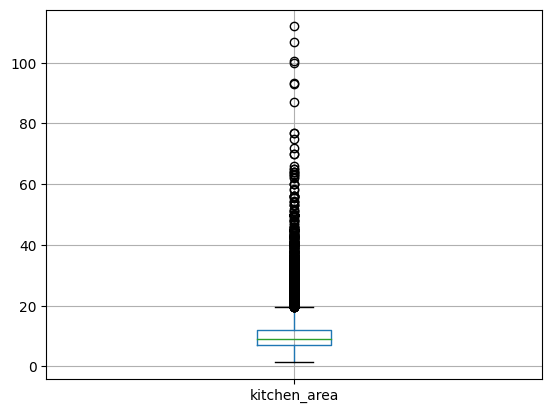

In [18]:
data.boxplot(column='kitchen_area');

Распределение основной доли значений сосредоточено в основном от 0 до 20 кв.м. Все значения ниже и выше этих значений являются выбросами. Поэтому медиана смещена к 10. Построим более масштабированный график в пределах этих границ.

(0.0, 20.0)

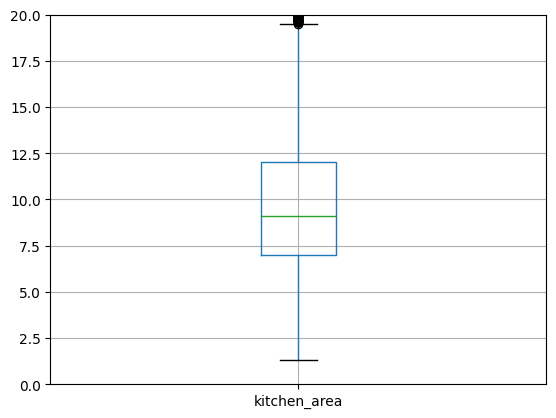

In [19]:
data.boxplot(column='kitchen_area')
plt.ylim(0, 20) # увеличим масштаб по оси ординат

In [20]:
data['kitchen_area'] = data['kitchen_area'].fillna(9.5) # заполняем пропущенные значения медианой 9.5

#### Обработка столбца `living_area`

Заполним столбец `living_area` медианным значением из среза данных, где выполняется условие `total_area > living_area + kitchen_area`. Такое условие учитывает, что в правой части неравенства не хватает площади санузла, коридоров и т.п. нежилой площади.

In [21]:
# заполним пустые строки жилой площади медианным значением в зависимости от насленного пункта и кол-ва комнат
for l in data['locality_name'].unique():    
    for n in data['rooms'].unique():
        data.loc[(data['rooms'] == n) & (data['living_area'].isna()), 'living_area'] = \
        data.loc[(data['rooms'] == n), 'living_area'].median()

In [22]:
# проверим сколько получилось квартир с "правильной" жилой площадью и "слишком большой", добавив новые столбцы
data['mixed_area'] = data['living_area'] + data['kitchen_area'] # смешанная пл. за исключением санузла, коридаров и т.п.
data['good_flats'] = data['total_area'] > data['mixed_area'] # помечаем данные
data['good_flats'].value_counts()

True     23189
False      510
Name: good_flats, dtype: int64

In [23]:
# сохраним срез квартир с "правильной" жилой площадью 
good_flats_stat = data.copy()
good_flats_stat = good_flats_stat.query('good_flats == True')

In [24]:
# обработаем квартиры с "слишком большой" жилой площадью
bad_flats_stat = data.copy()
bad_flats_stat = bad_flats_stat.query('good_flats == False')
bad_flats_stat[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area', 'total_area', 'good_flats']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats
184,Санкт-Петербург,1,6.2,26.10,32.30,30.2,False
220,Санкт-Петербург,1,9.0,28.00,37.00,37.0,False
227,Новый Свет,3,9.5,45.00,54.50,47.0,False
237,Санкт-Петербург,1,9.5,20.75,30.25,28.1,False
322,Выборг,1,9.5,17.60,27.10,25.0,False
...,...,...,...,...,...,...,...
23554,Санкт-Петербург,0,9.5,18.00,27.50,26.0,False
23579,Кудрово,1,9.5,18.00,27.50,24.8,False
23613,Парголово,3,9.5,45.00,54.50,52.0,False
23637,Бугры,0,9.5,17.00,26.50,26.0,False


Подкорректируем living_area (LA), исходя из того, что total_area (TA) известно, а остальные значения известны и вычислены: kitchen_area (KA), mixed_area (MA).
Найдем дельту между TA и MA - это будет оставшаяся нежилая площадь - санузла, коридора и т.п. delta = |TA - MA|.

In [25]:
bad_flats_stat['delta'] = abs(bad_flats_stat['total_area'] - bad_flats_stat['mixed_area'])
bad_flats_stat[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area', 'total_area', 'good_flats', 'delta']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats,delta
184,Санкт-Петербург,1,6.2,26.10,32.30,30.2,False,2.10
220,Санкт-Петербург,1,9.0,28.00,37.00,37.0,False,0.00
227,Новый Свет,3,9.5,45.00,54.50,47.0,False,7.50
237,Санкт-Петербург,1,9.5,20.75,30.25,28.1,False,2.15
322,Выборг,1,9.5,17.60,27.10,25.0,False,2.10
...,...,...,...,...,...,...,...,...
23554,Санкт-Петербург,0,9.5,18.00,27.50,26.0,False,1.50
23579,Кудрово,1,9.5,18.00,27.50,24.8,False,2.70
23613,Парголово,3,9.5,45.00,54.50,52.0,False,2.50
23637,Бугры,0,9.5,17.00,26.50,26.0,False,0.50


Вычислим новую жилую площадь new_living_area с учетом delta (NLA) по такой формуле:
NLA = TA - (KA + delta)

In [26]:
bad_flats_stat['new_living_area'] = bad_flats_stat['total_area'] - (bad_flats_stat['kitchen_area'] + bad_flats_stat['delta'])
bad_flats_stat[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area',
                'total_area', 'good_flats', 'delta', 'new_living_area']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats,delta,new_living_area
184,Санкт-Петербург,1,6.2,26.10,32.30,30.2,False,2.10,21.90
220,Санкт-Петербург,1,9.0,28.00,37.00,37.0,False,0.00,28.00
227,Новый Свет,3,9.5,45.00,54.50,47.0,False,7.50,30.00
237,Санкт-Петербург,1,9.5,20.75,30.25,28.1,False,2.15,16.45
322,Выборг,1,9.5,17.60,27.10,25.0,False,2.10,13.40
...,...,...,...,...,...,...,...,...,...
23554,Санкт-Петербург,0,9.5,18.00,27.50,26.0,False,1.50,15.00
23579,Кудрово,1,9.5,18.00,27.50,24.8,False,2.70,12.60
23613,Парголово,3,9.5,45.00,54.50,52.0,False,2.50,40.00
23637,Бугры,0,9.5,17.00,26.50,26.0,False,0.50,16.00


Вычислим новую смешанную площадь new_mixed_area с учетом delta (NMA) по такой формуле:
NMA = NLA + KA

In [27]:
bad_flats_stat['new_mixed_area'] = bad_flats_stat['new_living_area'] + (bad_flats_stat['kitchen_area'])
bad_flats_stat[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area',
                'total_area', 'good_flats', 'delta', 'new_living_area', 'new_mixed_area']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats,delta,new_living_area,new_mixed_area
184,Санкт-Петербург,1,6.2,26.10,32.30,30.2,False,2.10,21.90,28.10
220,Санкт-Петербург,1,9.0,28.00,37.00,37.0,False,0.00,28.00,37.00
227,Новый Свет,3,9.5,45.00,54.50,47.0,False,7.50,30.00,39.50
237,Санкт-Петербург,1,9.5,20.75,30.25,28.1,False,2.15,16.45,25.95
322,Выборг,1,9.5,17.60,27.10,25.0,False,2.10,13.40,22.90
...,...,...,...,...,...,...,...,...,...,...
23554,Санкт-Петербург,0,9.5,18.00,27.50,26.0,False,1.50,15.00,24.50
23579,Кудрово,1,9.5,18.00,27.50,24.8,False,2.70,12.60,22.10
23613,Парголово,3,9.5,45.00,54.50,52.0,False,2.50,40.00,49.50
23637,Бугры,0,9.5,17.00,26.50,26.0,False,0.50,16.00,25.50


Выполним проверку общей площади check_TA по новым площадям по такой формуле: TA = KA + delta + NLA

In [28]:
bad_flats_stat['check_TA'] = bad_flats_stat['kitchen_area'] + bad_flats_stat['delta'] + bad_flats_stat['new_living_area']
bad_flats_stat[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area',
                'total_area', 'good_flats', 'delta', 'new_living_area', 'new_mixed_area', 'check_TA']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats,delta,new_living_area,new_mixed_area,check_TA
184,Санкт-Петербург,1,6.2,26.10,32.30,30.2,False,2.10,21.90,28.10,30.2
220,Санкт-Петербург,1,9.0,28.00,37.00,37.0,False,0.00,28.00,37.00,37.0
227,Новый Свет,3,9.5,45.00,54.50,47.0,False,7.50,30.00,39.50,47.0
237,Санкт-Петербург,1,9.5,20.75,30.25,28.1,False,2.15,16.45,25.95,28.1
322,Выборг,1,9.5,17.60,27.10,25.0,False,2.10,13.40,22.90,25.0
...,...,...,...,...,...,...,...,...,...,...,...
23554,Санкт-Петербург,0,9.5,18.00,27.50,26.0,False,1.50,15.00,24.50,26.0
23579,Кудрово,1,9.5,18.00,27.50,24.8,False,2.70,12.60,22.10,24.8
23613,Парголово,3,9.5,45.00,54.50,52.0,False,2.50,40.00,49.50,52.0
23637,Бугры,0,9.5,17.00,26.50,26.0,False,0.50,16.00,25.50,26.0


In [29]:
# проверка столбцов на сходимость значений
if (bad_flats_stat['total_area'] == bad_flats_stat['check_TA']).all:
    print('сошлось, значит new_living_area вычислено верно')
else:
    print('не сошлось, значит new_living_area вычислено не верно')

сошлось, значит new_living_area вычислено верно


In [30]:
# перенесем новые значения из 'new_living_area' в 'living_area'
bad_flats_stat['living_area'] = bad_flats_stat['new_living_area']

In [31]:
# перенесем новые значения из 'new_mixed_area' в 'new_mixed_area'
bad_flats_stat['mixed_area'] = bad_flats_stat['new_mixed_area']

In [32]:
# удалим крайние лишние вспомогательные столбцы
bad_flats_stat = bad_flats_stat.drop(columns = ['delta', 'new_living_area', 'new_mixed_area', 'check_TA'], axis = 1)

In [33]:
bad_flats_stat

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,mixed_area,good_flats
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,21.90,5,NaN,...,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0,28.10,False
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.00,6,NaN,...,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0,37.00,False
227,13,2200000.0,47.0,2018-01-12T00:00:00,3,2.34,5.0,30.00,1,NaN,...,Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,45.0,39.50,False
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.65,-1.0,16.45,1,NaN,...,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0,25.95,False
322,6,2000000.0,25.0,2017-02-07T00:00:00,1,2.65,5.0,13.40,5,False,...,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,45.0,22.90,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23554,15,3350000.0,26.0,2018-09-07T00:00:00,0,2.65,19.0,15.00,8,NaN,...,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,24.50,False
23579,7,2350000.0,24.8,2018-06-07T00:00:00,1,2.65,10.0,12.60,2,NaN,...,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,89.0,22.10,False
23613,4,3950000.0,52.0,2018-03-04T00:00:00,3,2.65,5.0,40.00,2,NaN,...,Парголово,55549.0,21223.0,0.0,NaN,0.0,NaN,45.0,49.50,False
23637,8,2350000.0,26.0,2018-06-26T00:00:00,0,2.65,25.0,16.00,4,NaN,...,Бугры,NaN,NaN,NaN,NaN,NaN,NaN,207.0,25.50,False


In [34]:
good_flats_stat

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,mixed_area,good_flats
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,76.00,True
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,...,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,29.60,True
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,42.60,True
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,54.50,True
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,73.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,87.13,True
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.0,4,NaN,...,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,46.50,True
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.7,1,NaN,...,Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.20,True
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,30.5,12,NaN,...,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,53.80,True


In [35]:
# чтобы не нарушать порядок индексов используем конкатенацию по строкам
data_new = pd.concat([good_flats_stat, bad_flats_stat], axis=0)

Сделаем проверку на аномалии в новом датафрейме

In [36]:
# смешанная пл. за исключением санузла, коридаров и т.п.
data_new['mixed_area'] = data_new['living_area'] + data_new['kitchen_area']
data_new['good_flats'] = data_new['total_area'] > data_new['mixed_area'] # помечаем данные
data_new['good_flats'].value_counts()

True     23623
False       76
Name: good_flats, dtype: int64

Снова найдены отклонения, посмотрим на них.

In [37]:
data_q = data_new.query('good_flats == False')
data_q[['locality_name', 'rooms', 'kitchen_area', 'living_area', 'mixed_area', 'total_area', 'good_flats']]

,locality_name,rooms,kitchen_area,living_area,mixed_area,total_area,good_flats
220,Санкт-Петербург,1,9.0,28.0,37.0,37.0,False
1776,Санкт-Петербург,2,10.0,54.0,64.0,64.0,False
1781,Луга,2,8.0,26.0,34.0,34.0,False
2138,Кудрово,1,10.8,25.7,36.5,36.5,False
2296,Гаврилово,1,9.4,17.0,26.4,26.4,False
...,...,...,...,...,...,...,...
22693,Санкт-Петербург,2,25.0,57.4,82.4,82.4,False
22869,Санкт-Петербург,1,11.0,14.0,25.0,25.0,False
22963,Кингисепп,5,24.0,78.0,102.0,102.0,False
23297,Высоцк,2,6.0,42.2,48.2,48.2,False


In [38]:
data.loc[220] # посмотрим на первое значение из исходного датафрейма

total_images                              8
last_price                        3890000.0
total_area                             37.0
first_day_exposition    2018-07-09T00:00:00
rooms                                     1
ceiling_height                          2.5
floors_total                           25.0
living_area                            28.0
floor                                     6
is_apartment                            NaN
studio                                False
open_plan                             False
kitchen_area                            9.0
balcony                                 NaN
locality_name               Санкт-Петербург
airports_nearest                    25408.0
cityCenters_nearest                 16166.0
parks_around3000                        0.0
parks_nearest                           NaN
ponds_around3000                        0.0
ponds_nearest                           NaN
days_exposition                        28.0
mixed_area                      

В срез попали объявления, которые не были заполнены синтетическими данными, у которых смешанная площадь равна общей. Эти аномальные данные не повлияют на анализ, т.к. они не учитывают только санузел, коридор и т.п., которые не входят в цену за кв.м. квартиры.

In [39]:
data = data_new.copy() # вернем исходное название датафрейму

In [40]:
# удалим крайние лишние вспомогательные столбцы
data = data.drop(columns = ['mixed_area', 'good_flats'], axis = 1)

#### Обработка столбца `is_apartment`

Заполним столбец `is_apartment`. Для этого сравним срезы по его заполненным значениям: True и False со всеми возможными комбинациями значений столбцов `studio` и `open_plan`, которые полностью заполнены.

In [41]:
data['is_apartment'].count() # количесвто заполненных значений

2775

In [42]:
print(data.query('is_apartment == False and (studio == False and open_plan == False)').shape[0])
print(data.query('is_apartment == False and (studio == True and open_plan == False)').shape[0])
print(data.query('is_apartment == False and (studio == False and open_plan == True)').shape[0])
print(data.query('is_apartment == False and (studio == True and open_plan == True)').shape[0])

2703
15
7
0


In [43]:
print(data.query('is_apartment == True and (studio == False and open_plan == False)').shape[0])
print(data.query('is_apartment == True and (studio == True and open_plan == False)').shape[0])
print(data.query('is_apartment == True and (studio == False and open_plan == True)').shape[0])
print(data.query('is_apartment == True and (studio == True and open_plan == True)').shape[0])

50
0
0
0


Как видно из сравнения двух групп срезов - в первой `is_apartment` = **False** находятся почти все комбинации значений по столбцам `studio` и `open_plan`, кроме True и True. Но для этой же комбинаций во втрой группе срезов `is_apartment` = **True** совпадения не найдены. Следовательно можно заполнить все пустые значения столбца `is_apartment` значениями **False**.

In [44]:
data['is_apartment'] = data['is_apartment'].fillna('0') # заполняем пропуски нулем, т.е. 'False'
data['is_apartment'] = data['is_apartment'].apply(bool) # переводим в булев тип

#### Обработка столбца `balcony`

Столбец `balcony` будем заполнять медианным значением в зависимости от количетсва комнат. Количество балконов не может превышать количества комнат. Нерепрезентативные выборки исключим из заполнения.

In [45]:
# количетсво квартир с балконами по количеству комнат
print(data.pivot_table(index='rooms', values='balcony', aggfunc=('count')))

       balcony
rooms         
0          126
1         4228
2         4130
3         2954
4          528
5          139
6           37
7           27
8            4
9            2
10           3
11           0
12           0
14           1
15           0
16           1
19           0


Ниже рассмотрим только 1, 2, 3, 4 квартиры.

count    2701.000000
mean        0.544983
std         0.498065
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: balcony, dtype: float64


<AxesSubplot:xlabel='rooms', ylabel='balcony'>

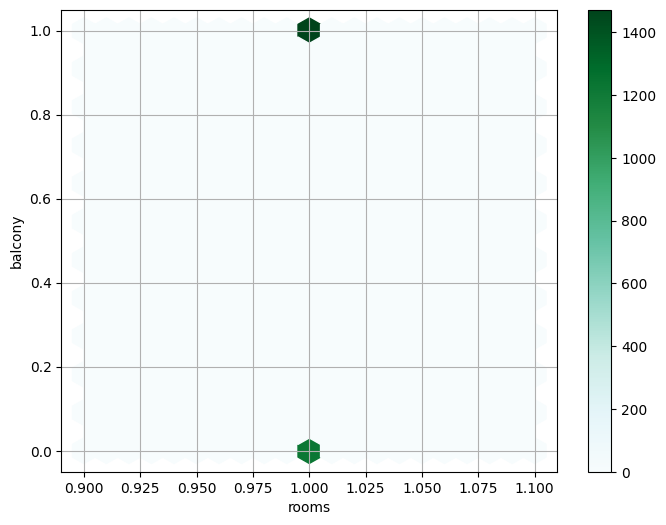

In [46]:
# срез по однокомнатным квартирам с количеством балконов 0-1
print(data.query('(rooms == 1) and (0 <= balcony <= 1)')['balcony'].describe())
data.query('(rooms == 1) and (0 <= balcony <= 1)').plot(x='rooms', y='balcony',
                                                        kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

In [47]:
# заполняем однокомнатные квартиры медианой, равной 1
data.loc[(data['rooms'] == 1) & (data['balcony'].isna()), 'balcony'] = 1

count    3965.000000
mean        0.969735
std         0.780432
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: balcony, dtype: float64


<AxesSubplot:xlabel='rooms', ylabel='balcony'>

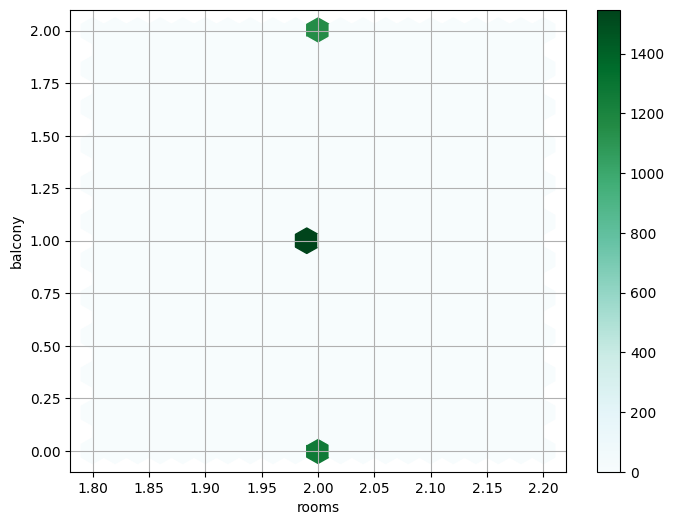

In [48]:
# срез по двухкомнатным квартирам с количеством балконов 0-2
print(data.query('(rooms == 2) and (0 <= balcony <= 2)')['balcony'].describe())
data.query('(rooms == 2) and (0 <= balcony <= 2)').plot(x='rooms', y='balcony',
                                                        kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

In [49]:
# заполняем двухкомнатные квартиры медианой, равной 1
data.loc[(data['rooms'] == 2) & (data['balcony'].isna()), 'balcony'] = 1

count    2705.000000
mean        0.997043
std         0.840888
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: balcony, dtype: float64


<AxesSubplot:xlabel='rooms', ylabel='balcony'>

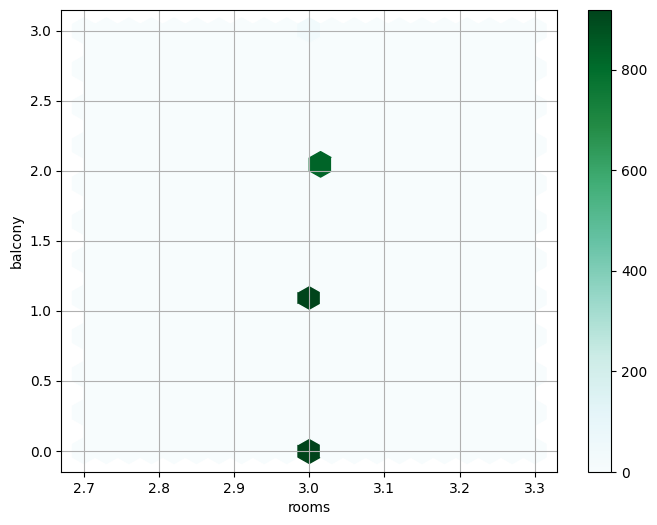

In [50]:
# срез по трехкомнатным квартирам с количеством балконов 0-3
print(data.query('(rooms == 3) and (0 <= balcony <= 3)')['balcony'].describe())
data.query('(rooms == 3) and (0 <= balcony <= 3)').plot(x='rooms', y='balcony',
                                                        kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

Доля трехкомнатных квартир без балкона и с 1 балконом практически равны, но еще есть часть квартир с двумя балконами, поэтому в качестве усредненного значения лучше взять значение равное 1.

In [51]:
# заполняем трехкомнатные квартиры значением равным 1
data.loc[(data['rooms'] == 3) & (data['balcony'].isna()), 'balcony'] = 1

count    505.000000
mean       0.883168
std        1.017805
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: balcony, dtype: float64


<AxesSubplot:xlabel='rooms', ylabel='balcony'>

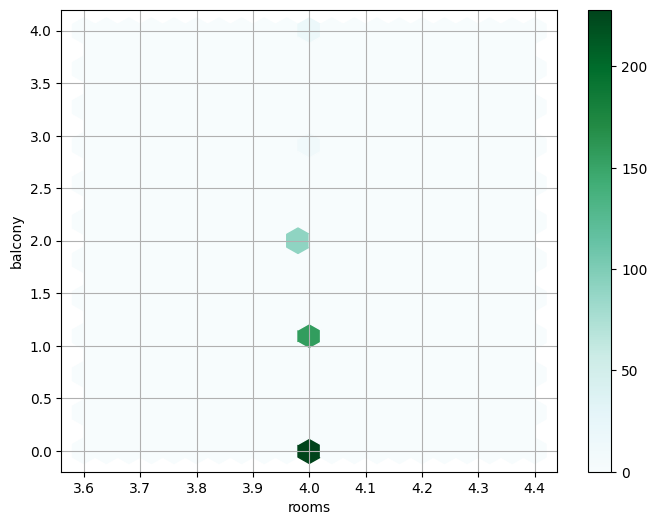

In [52]:
# срез по четырехкомнатным квартирам с количеством балконов 0-4
print(data.query('(rooms == 4) and (0 <= balcony <= 4)')['balcony'].describe())
data.query('(rooms == 4) and (0 <= balcony <= 4)').plot(x='rooms', y='balcony', 
            kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
           

In [53]:
# заполняем четырехкомнатные квартиры значением равным 0
data.loc[(data['rooms'] == 4) & (data['balcony'].isna()), 'balcony'] = 0

Осташиеся квартиры с пропущенным количеством балконов заменяем на ноль, так как считаем, что, если их не указали, значит их нет.

In [54]:
data['balcony'] = data['balcony'].fillna(0) # заменяем оставшиеся пропущенное кол-во балконов на "0"

#### Обработка столбцов, заполняющихся автоматически

Все остальные столбцы заполняются автоматически, но в них тоже есть пропуски. Заполним пропущенные значения в `parks_around3000` и `ponds_around3000` нулями (кол-во парков и кол-во прудов).

In [55]:
data.isna().sum() # оставшиеся пропущенные значения

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Обнаружены одинакавые пропуски в 5518 строках в двух столбцах. Скорее всего там нет парков и водоемов, поэтому заполним их нулями.

In [56]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Столбец `days_exposition` оставим незаполненным. Остальные оставшиеся столбцы заполним заглушкой -1.

In [57]:
data['airports_nearest'] = data['airports_nearest'].fillna(-1)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1)
data['parks_nearest'] = data['parks_nearest'].fillna(-1)
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1)

In [58]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3181
dtype: int64

In [59]:
data.info() # проверяем еще раз после заполнения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23680
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [60]:
# заменим типы данных с вещественных на целые 
data['floors_total'] = data['floors_total'].apply(int)
data['balcony'] = data['balcony'].apply(int)

##### Проверка данных на аномалии

In [61]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","23,699.00","20,518.00","23,699.00","23,699.00","23,699.00","23,699.00","23,699.00"
min,0.00,12.00,1.00,1.00,"12,190.00",-12.00,1.30,1.00,-1.00
max,19.00,900.00,24.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


Отфильтруем квартиры с выбросами по каждому параметру и пометим их по такому принципу:

*в размах «усов» попадают нормальные значения, а за пределами находятся выбросы, изображённые точками. Если правый «ус» длиннее максимума, то он заканчивается максимумом. То же — для минимума и левого «уса».*
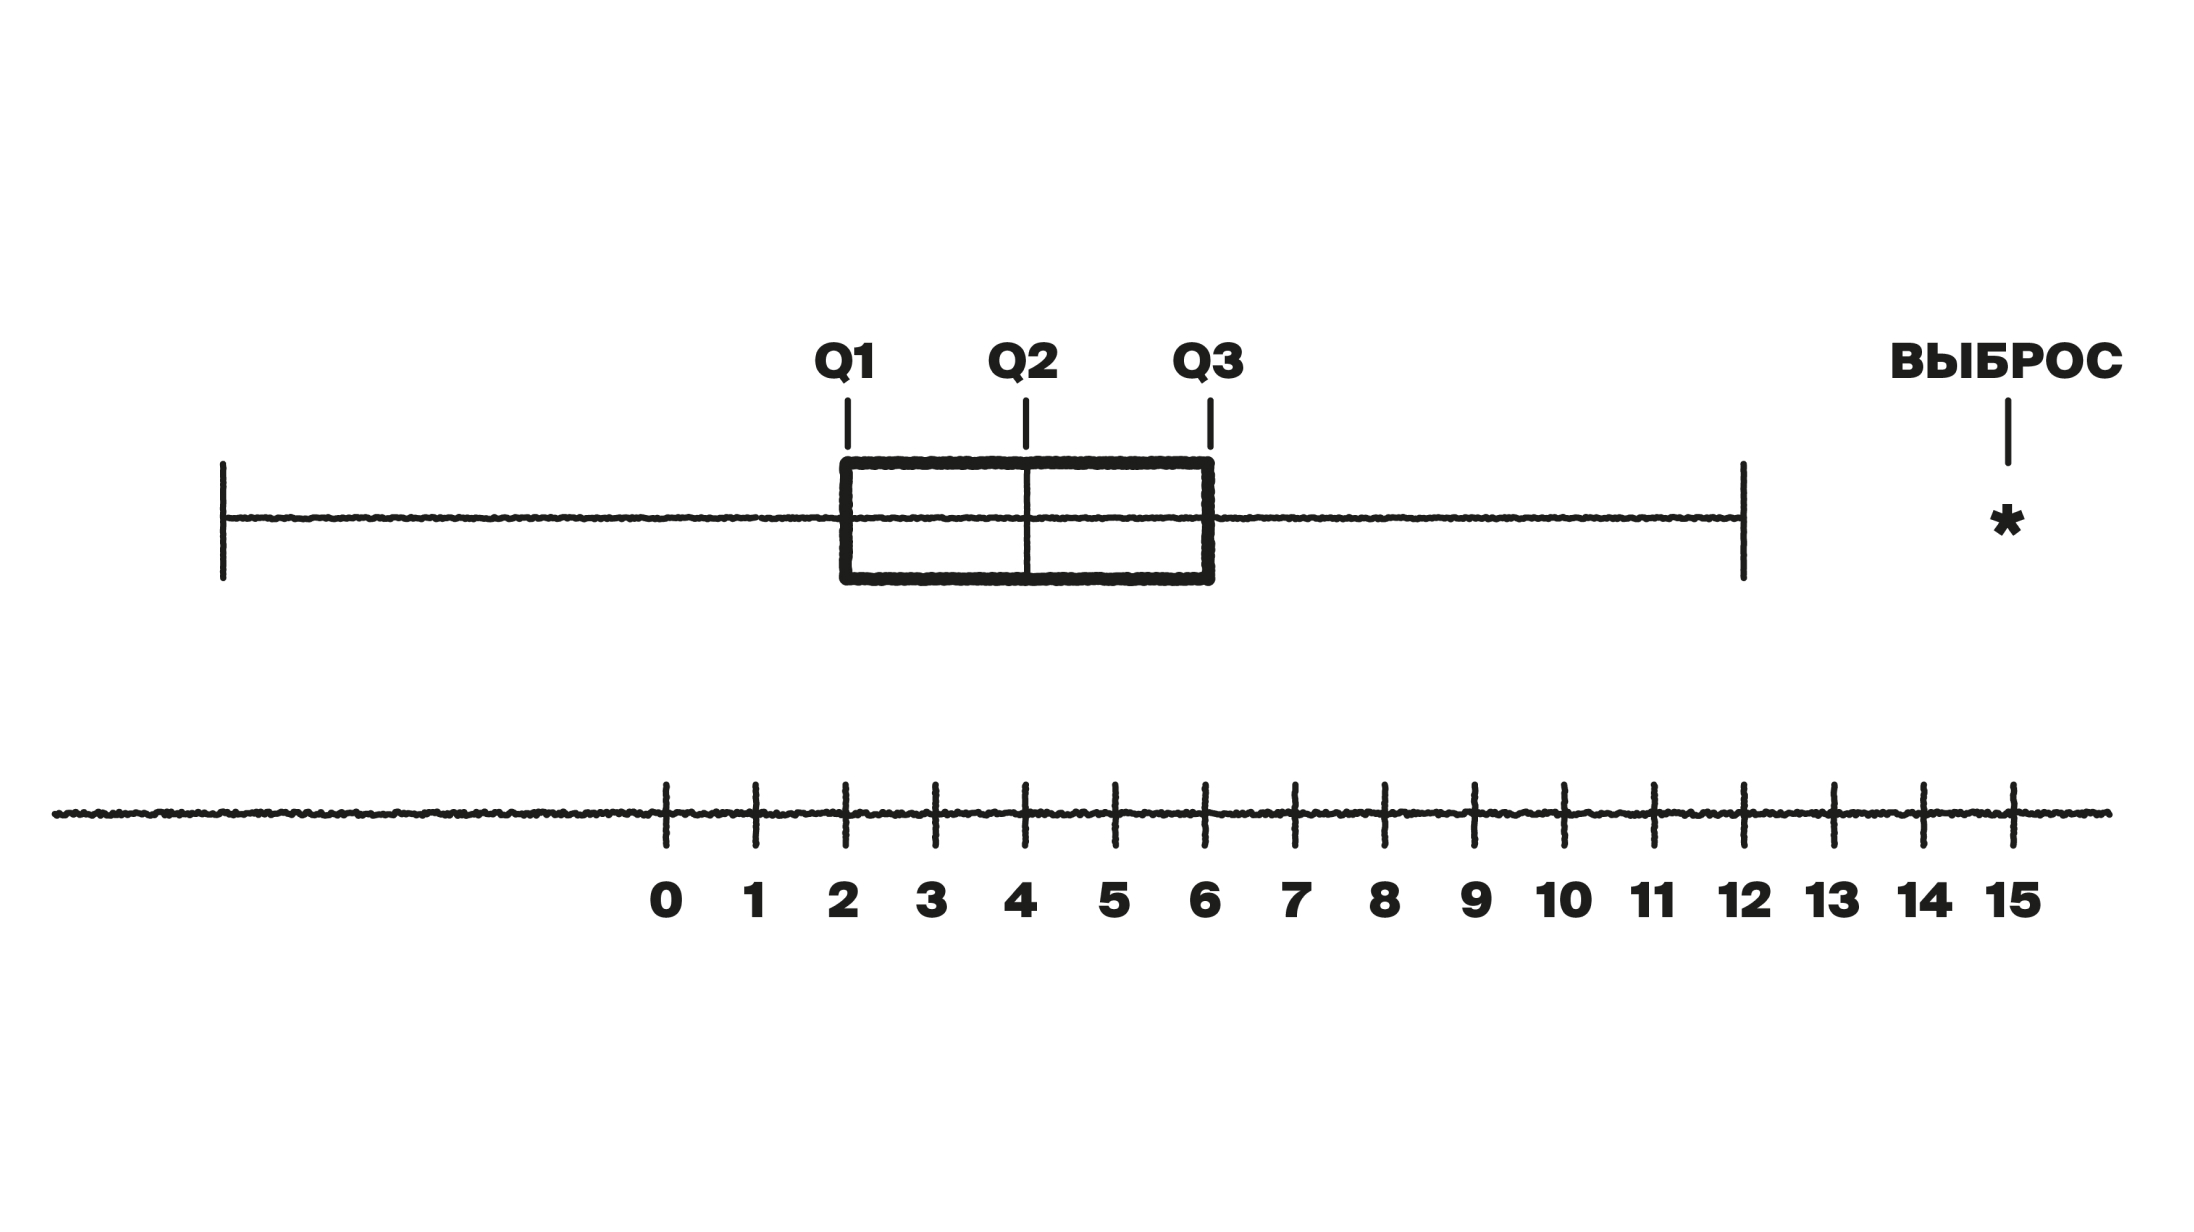

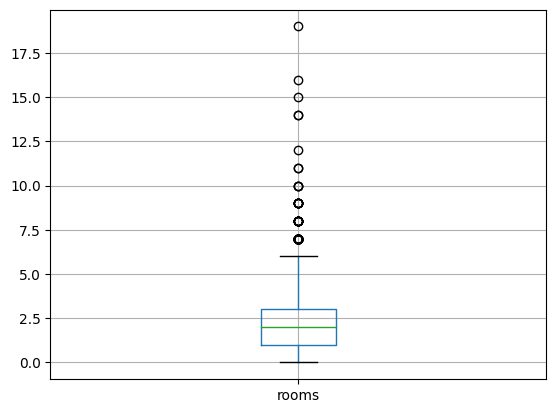

In [62]:
data.boxplot(column='rooms');

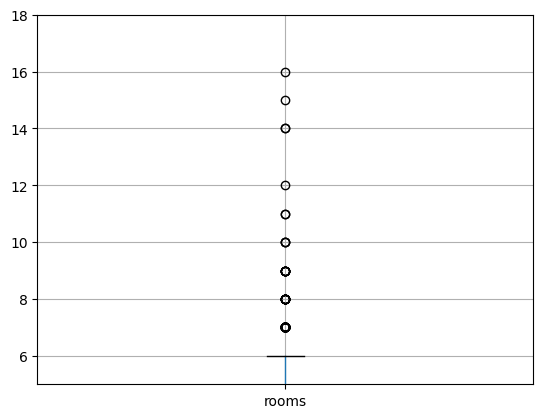

In [63]:
data.boxplot(column='rooms')
plt.ylim(5, 18);

In [64]:
# Квартиры больше 6 комнат - редкие. 0 комнат - это студии.
data['rooms_gap'] = data['rooms'] > 6 # помечаем данные
data['rooms_gap'].value_counts()

False    23609
True        90
Name: rooms_gap, dtype: int64

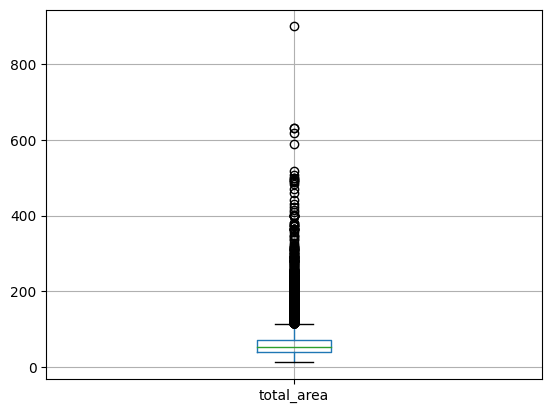

In [65]:
data.boxplot(column='total_area');

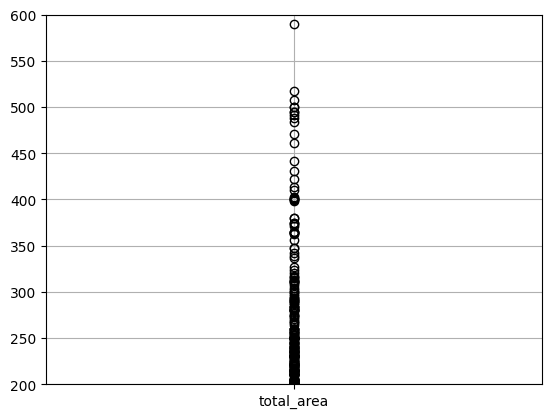

In [66]:
data.boxplot(column='total_area')
plt.ylim(200, 600);

In [67]:
# Квартиры больше 300 кв. м. - редкие.
data['total_area_gap'] = data['total_area'] > 300 # помечаем данные
data['total_area_gap'].value_counts()

False    23638
True        61
Name: total_area_gap, dtype: int64

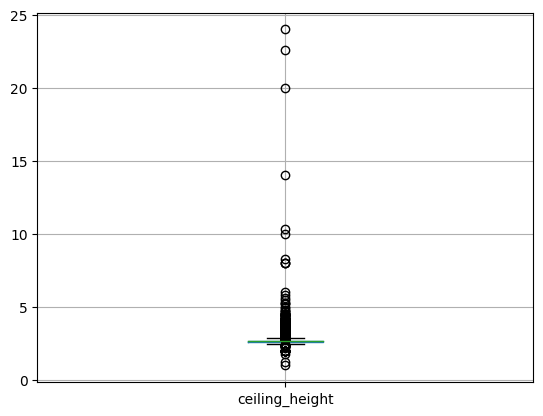

In [68]:
data.boxplot(column='ceiling_height');

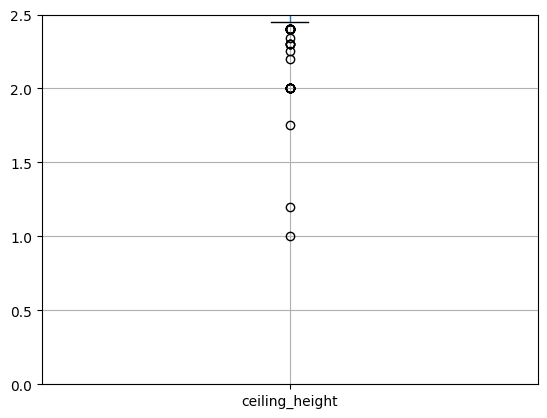

In [69]:
data.boxplot(column='ceiling_height')
plt.ylim(0, 2.5);

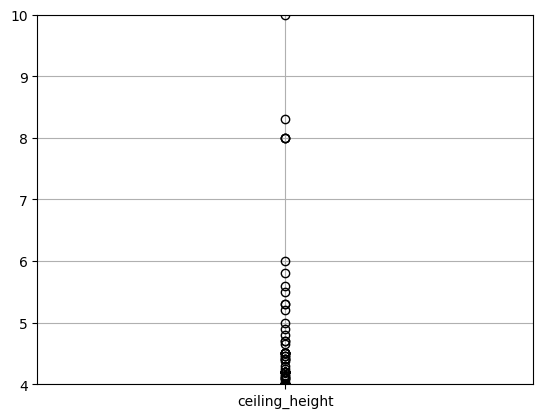

In [70]:
data.boxplot(column='ceiling_height')
plt.ylim(4, 10);

In [71]:
# Квартиры с высотой потолка меньше 2.4 м. или больше 4.2 м. - редкие.
data['ceiling_height_gap'] = (data['ceiling_height'] < 2.4) | (data['ceiling_height'] > 4.2) # помечаем данные
data['ceiling_height_gap'].value_counts()

False    23640
True        59
Name: ceiling_height_gap, dtype: int64

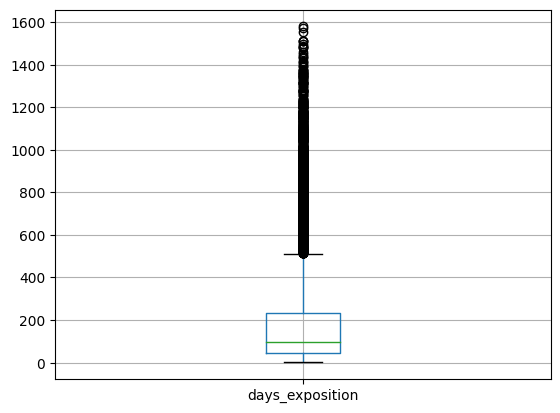

In [72]:
data.boxplot(column='days_exposition');

In [73]:
# Квартиры с количеством дней на продажу оставляем все
data['days_exposition_gap'] = data['days_exposition'] > 17000 # помечаем данные
data['days_exposition_gap'].value_counts()

False    23699
Name: days_exposition_gap, dtype: int64

In [74]:
data['last_price_new'] = data['last_price'] / 1000000 # добавим вспомогательный столбец для избавления от нулей

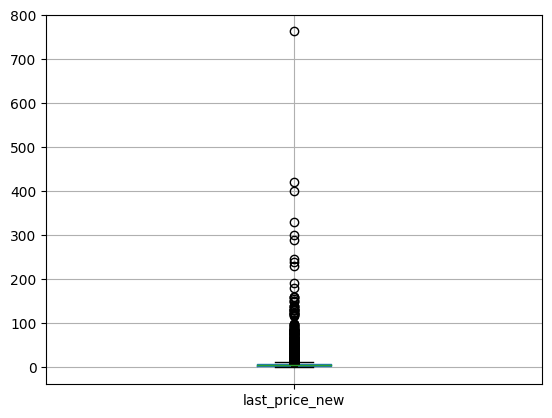

In [75]:
data.boxplot(column='last_price_new');

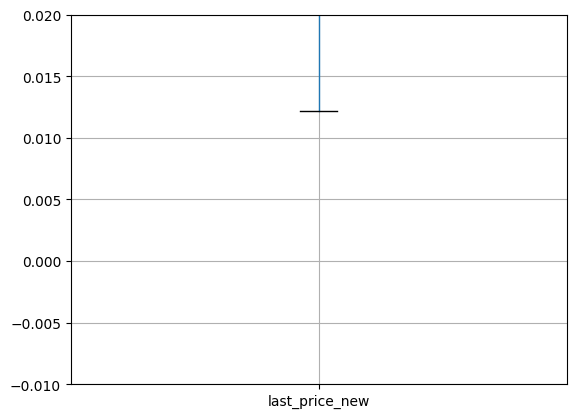

In [76]:
data.boxplot(column='last_price_new')
plt.ylim(-0.01, 0.02);

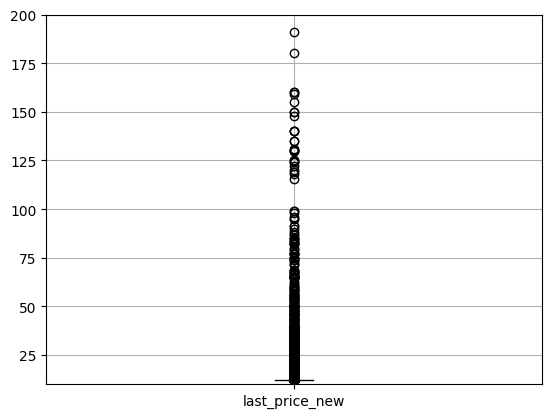

In [77]:
data.boxplot(column='last_price_new')
plt.ylim(10, 200);

In [78]:
data = data.drop(columns = ['last_price_new'], axis = 1) # удалим вспомогательный столбец

In [79]:
# Квартиры с ценой проджажи выше 170 млн. руб - редкие.
data['last_price_gap'] = (data['last_price'] > 100000000) # помечаем данные
data['last_price_gap'].value_counts()

False    23662
True        37
Name: last_price_gap, dtype: int64

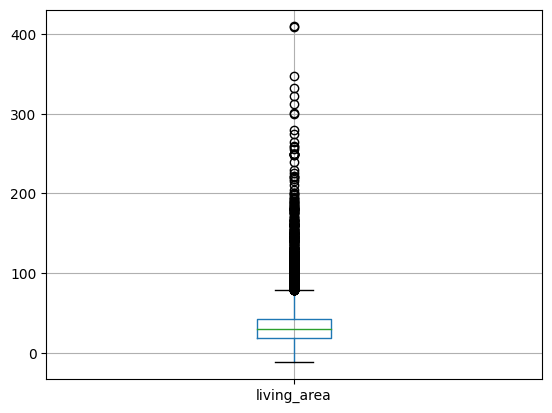

In [80]:
data.boxplot(column='living_area');

In [81]:
data['living_area'] = abs(data['living_area']) # в минимуме обнаружен отрицательное значение, уберем его через модуль

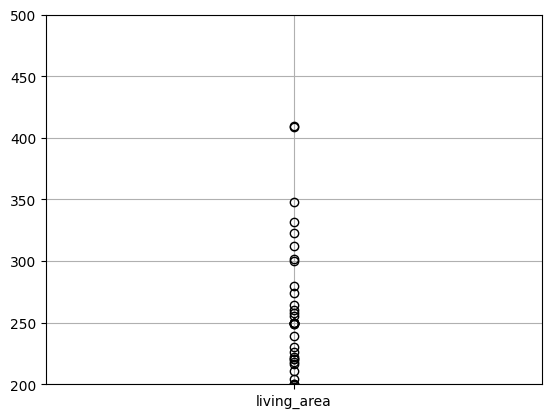

In [82]:
data.boxplot(column='living_area')
plt.ylim(200, 500);

In [83]:
# Квартиры с жилой площадью больше 230 кв.м. - редкие.
data['living_area_gap'] = ((data['living_area'] < 7) | (data['living_area'] > 230)) # помечаем данные
data['living_area_gap'].value_counts()

False    23630
True        69
Name: living_area_gap, dtype: int64

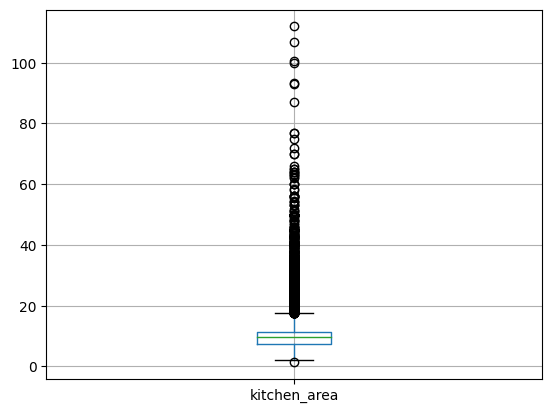

In [84]:
data.boxplot(column='kitchen_area');

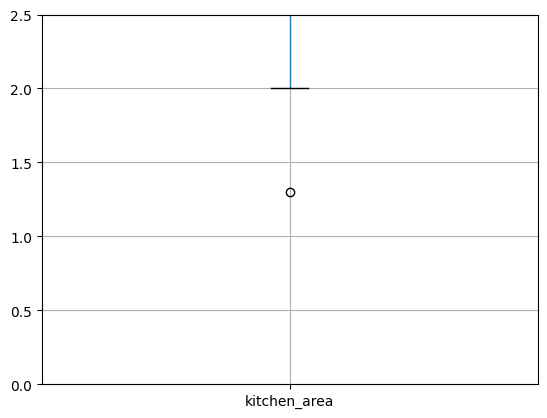

In [85]:
data.boxplot(column='kitchen_area')
plt.ylim(0, 2.5);

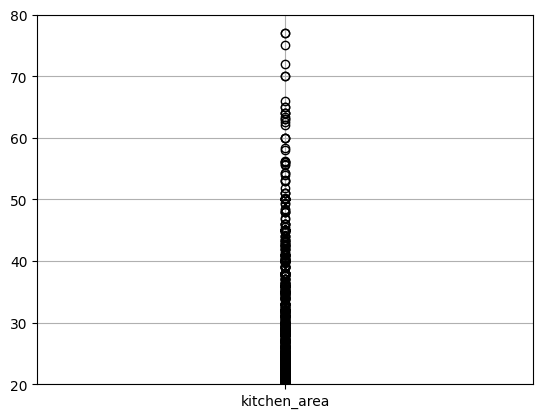

In [86]:
data.boxplot(column='kitchen_area')
plt.ylim(20, 80);

In [87]:
# Квартиры с площадью кухни меньше 2 кв.м. или больше 45 кв.м. - редкие.
data['kitchen_area_gap'] = ((data['kitchen_area'] < 2) | (data['kitchen_area'] > 45)) # помечаем данные
data['kitchen_area_gap'].value_counts()

False    23626
True        73
Name: kitchen_area_gap, dtype: int64

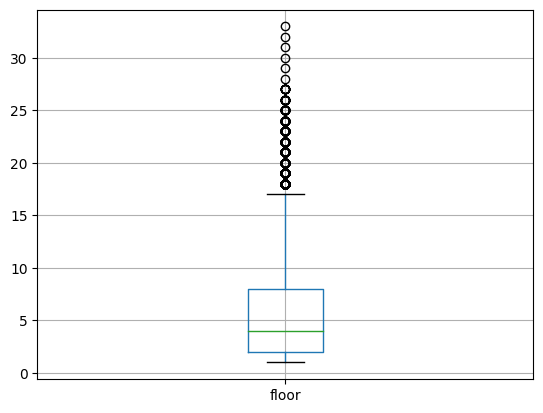

In [88]:
data.boxplot(column='floor');

In [89]:
# Квартиры с этажами оставим все.
data['floor_gap'] = (data['floor'] > 40) # помечаем данные
data['floor_gap'].value_counts()

False    23699
Name: floor_gap, dtype: int64

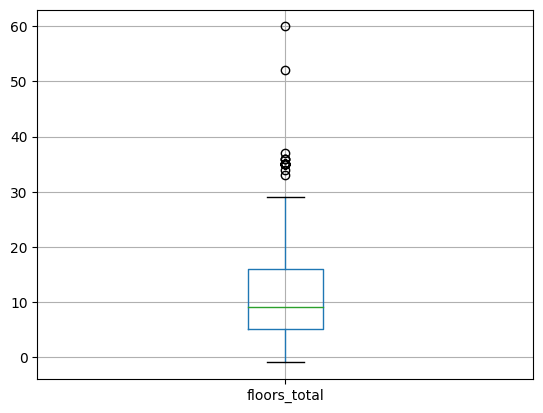

In [90]:
data.boxplot(column='floors_total');

In [91]:
# Квартиры с этажностью осталвяем все.
data['floors_total_gap'] = (data['floors_total'] > 70) # помечаем данные
data['floors_total_gap'].value_counts()

False    23699
Name: floors_total_gap, dtype: int64

In [92]:
# отфильтруем помеченные данные
nogap_data = (
    data.query('rooms_gap == False and total_area_gap == False and \
               ceiling_height_gap == False and days_exposition_gap == False and \
               days_exposition_gap == False and last_price_gap == False and \
               living_area_gap == False and kitchen_area_gap == False and \
               floor_gap == False and floors_total_gap == False')
            )
nogap_data.shape[0]

23403

Проверка очищенных данных и полученных после предобработки.

In [93]:
(
    nogap_data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,403.00","23,403.00","23,403.00","20,283.00","23,403.00","23,403.00","23,403.00","23,403.00","23,403.00"
min,0.00,13.00,2.40,1.00,"12,190.00",7.00,2.00,1.00,-1.00
max,6.00,300.00,4.20,"1,580.00","99,000,000.00",200.00,45.00,33.00,60.00


In [94]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","23,699.00","20,518.00","23,699.00","23,699.00","23,699.00","23,699.00","23,699.00"
min,0.00,12.00,1.00,1.00,"12,190.00",0.00,1.30,1.00,-1.00
max,19.00,900.00,24.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [95]:
nogap_data.shape[0] / data.shape[0] * 100

98.75100215198952

Данные улучшены, потери составили меньше 2%

In [96]:
data = nogap_data.copy() # вернем датафрейму начальное название

# удалим крайние лишние вспомогательные столбцы
data = data.drop(columns = ['rooms_gap', 'total_area_gap', 'ceiling_height_gap', 'days_exposition_gap',
                            'last_price_gap', 'living_area_gap', 'kitchen_area_gap', 'floor_gap', 'floors_total_gap'], axis = 1)

### Посчитайте и добавьте в таблицу новые столбцы

#### Расчет цены одного квадратного метра

Рассчитаем цену одного квадратного метра. Для этого создадим новый столбец `m2_price`, в котором поделим значения столбца `last_price` на значения столбца `total_area`.

In [97]:
data['m2_price'] = round(data['last_price'] / data['total_area'])

In [98]:
data[['m2_price', 'last_price', 'total_area']].head(5)

,m2_price,last_price,total_area
0,120370.0,13000000.0,108.0
1,82921.0,3350000.0,40.4
2,92786.0,5196000.0,56.0
3,408176.0,64900000.0,159.0
4,100000.0,10000000.0,100.0


#### Расчет дня, месяца и года публикации

Для рассчета дня, месяца и года публикации преобразуем столбец `first_day_exposition` в формат времени.

In [99]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['weekday'] = data['first_day_exposition'].dt.weekday # день
data['month'] = data['first_day_exposition'].dt.month     # месяц
data['year'] = data['first_day_exposition'].dt.year       # год

In [100]:
data[['weekday', 'month', 'year']].head(5)

,weekday,month,year
0,3,3,2019
1,1,12,2018
2,3,8,2015
3,4,7,2015
4,1,6,2018


#### Расчет столбца `type_floor`

Для проставления типа этажа создадим столбец `type_floor` и напишем функцию для его заполнения.

In [101]:
def group_floor(row): # функция определения типа этажа
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [102]:
data['type_floor'] = data.apply(group_floor, axis=1)

In [103]:
data[['type_floor', 'floor', 'floors_total']].head(5)

,type_floor,floor,floors_total
0,другой,8,16
1,первый,1,11
2,другой,4,5
3,другой,9,14
4,другой,13,14


#### Расчет расстояния в км до центра города

Для расчета расстояния в км до центра города поделим столбец `cityCenters_nearest` на 1000, чтобы перевести м в км. Создадим новый столбец `cityCenters_nearest_km`.

In [104]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)

In [105]:
data[['cityCenters_nearest', 'cityCenters_nearest_km']].head(5)

,cityCenters_nearest,cityCenters_nearest_km
0,16028.0,16.0
1,18603.0,19.0
2,13933.0,14.0
3,6800.0,7.0
4,8098.0,8.0


### Проведите исследовательский анализ данных

#### Исследование параметров квартир

Исследуем следующие параметры квартир:

        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
        
Сгруппируем данные по характеристикам, над которыми можно произвести общие действия: 
1. посчитать сумму и среднее в данных, где данные вносились вручную. Построить гистограммы.
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - день и месяц публикации объявления.

2. посчитать среднее значение, где в данных есть "заглушки". Построить гистограммы.
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка.

*Первый тип данных.*

In [106]:
data[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor',
      'weekday', 'month']].agg(['sum', 'median']).style.format("{:,.2f}")

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,weekday,month
sum,"1,374,104.83","780,178.19","240,049.18","141,744,362,393.00","47,778.00","62,995.32","138,102.00","60,103.00","149,808.00"
median,52.00,30.10,9.50,"4,600,000.00",2.00,2.65,4.00,3.00,6.00


Типичная усредненная квартира: 
общая площадь 51 кв.м.
жилая площадь - 30 кв.м.
площадь кухни - 9.5 кв.м.
цена продажи - 4.5 млн. руб.
кол-во комнат - 2
высота потолка - 2.65 м.
этаж - 4
выставляли на продажу - в конце рабочей недели летом (чт, июль)

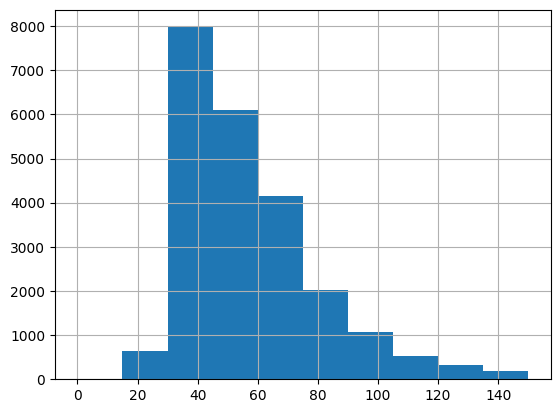

In [107]:
data['total_area'].hist(bins=10, range=(0,150));

Продаются в основном квартиры от 30 до 120 кв. м. Средняя общая площадь квартир 51 кв.м. 

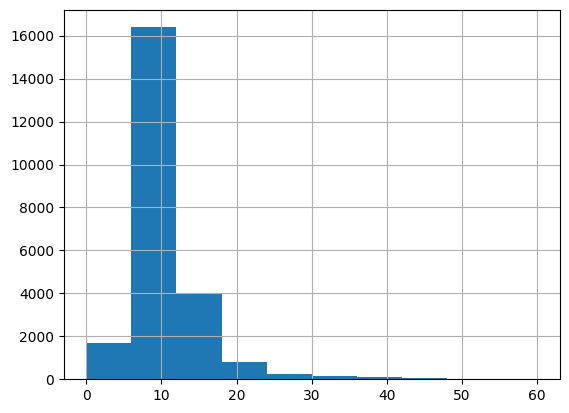

In [108]:
data['kitchen_area'].hist(bins=10, range=(0,60));

Продаются в основном кухни от 5 до 23 кв. м. Средняя общая площадь квартир 9.5 кв.м. 

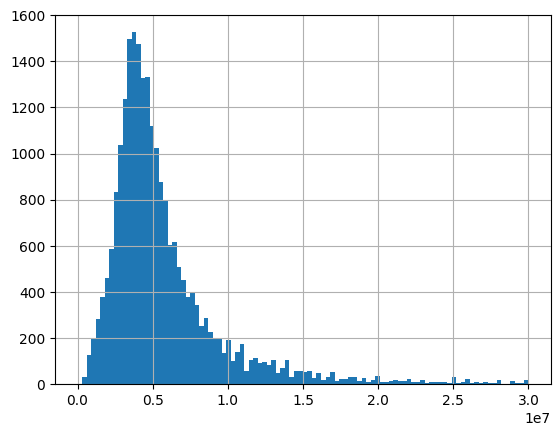

In [109]:
data['last_price'].hist(bins=100, range=(0, 30000000));

Диапозон цен продаж очень широкий - от нескольких сотен тысяч до нескольких десятков миллионов руб. Медианная цена - 4,5 млн. руб

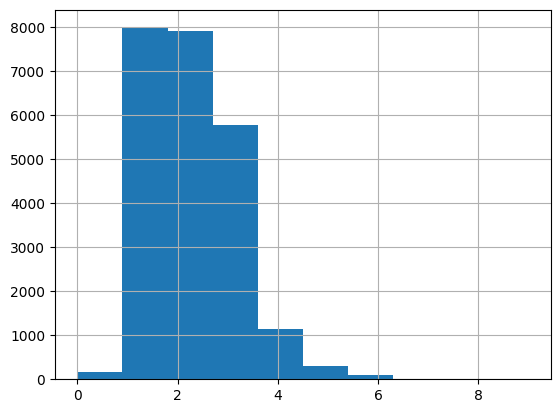

In [110]:
data['rooms'].hist(bins=10, range=(0, 9));

В основном продаются 1-4 комнатные квартиры, преобладают двухкомнатные.

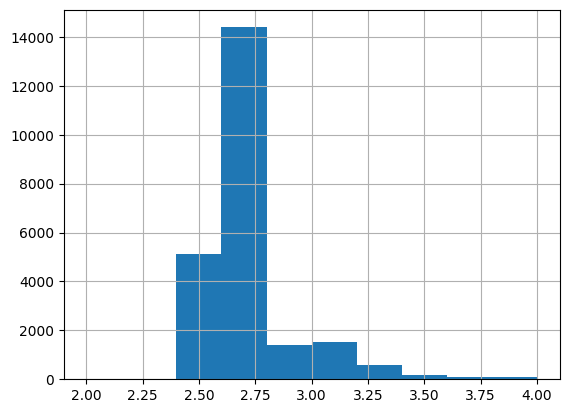

In [111]:
data['ceiling_height'].hist(bins=10, range=(2, 4));

В основном высота потолка составляет 2.65 м.

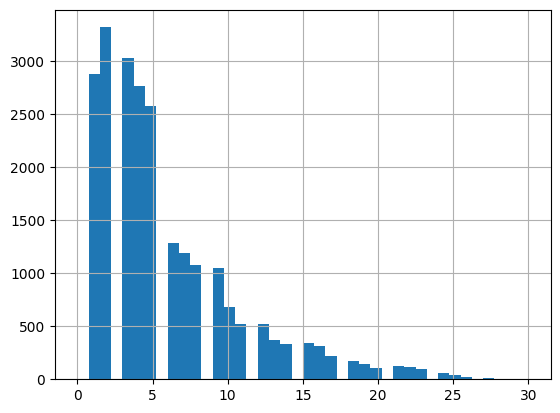

In [112]:
data['floor'].hist(bins=40, range=(0, 30));

В основном квартиры продаются на невысоких этажах, самые популярные 1-5 этажи.

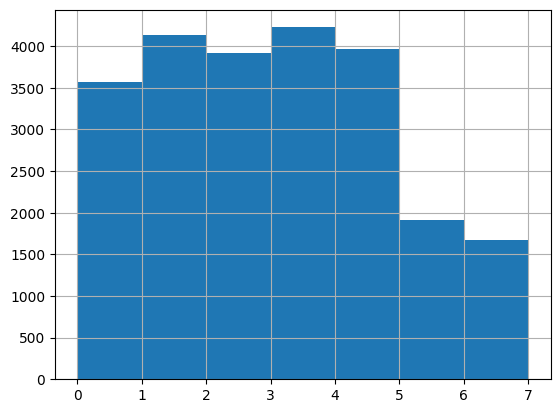

In [113]:
data['weekday'].hist(bins=7, range=(0, 7));

Объявления в основном размещают в будние дни.

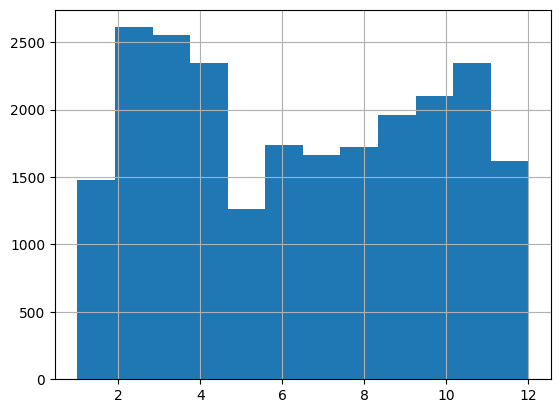

In [114]:
data['month'].hist(bins=12, range=(1, 12));

В осенне-зимний сезон продажи падают, наблюдается только всплеск в феврале. В летне-весенний сезон продажи увеличиваются, наблюдается только провал в мае.

*Второй тип данных.*

In [115]:
# количество этажей по типу: первый, последний, другой
data['type_floor'].value_counts()

другой       17267
последний     3257
первый        2879
Name: type_floor, dtype: int64

<AxesSubplot:>

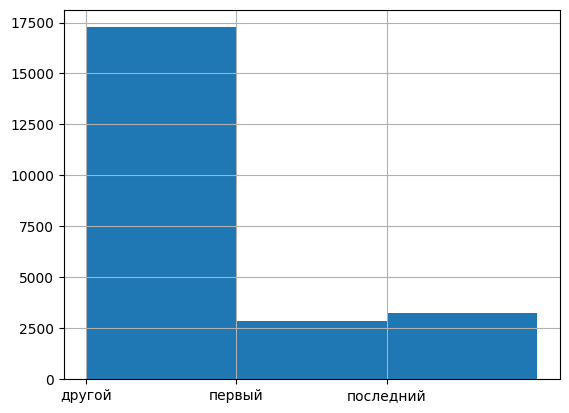

In [116]:
data['type_floor'].hist(bins=3, range=(0, 3))

Проданных первых и последних этажей в сумме довольно много: их всего лишь почти в 2.6 раза меньше, чем всех остальных вместе взятых.

In [117]:
 # срез по количеству этажей в доме кроме -1
data.query('floors_total != -1')['floors_total'].value_counts().head(3)

5     5714
9     3743
16    1368
Name: floors_total, dtype: int64

<AxesSubplot:>

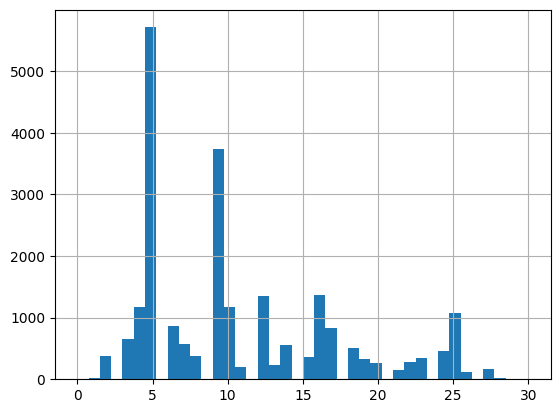

In [118]:
data.query('floors_total != -1')['floors_total'].hist(bins=40, range=(0,30))

Самые популярные дома - пяти и девятиэтажки.

In [119]:
# срез по удаленности от центра кроме -1
data.query('cityCenters_nearest != -1')['cityCenters_nearest'].median()

13149.0

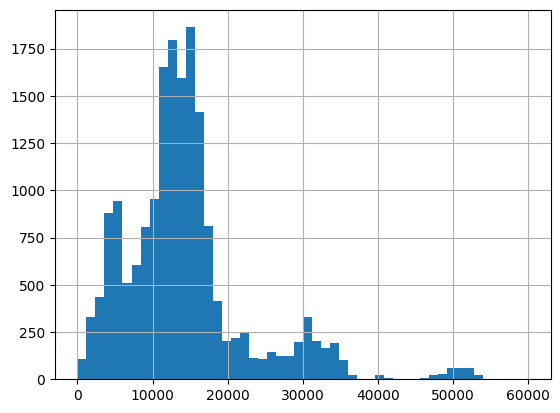

In [120]:
data.query('cityCenters_nearest != -1')['cityCenters_nearest'].hist(bins=50, range=(0,60000));

Удаленность квартир от центра от 0 до 55 000 м. Средняя - 13 тыс метров.

In [121]:
# срез по удаленности квартир до ближайшего аэропорта кроме -1
data.query('airports_nearest != -1')['airports_nearest'].median()

26798.0

<AxesSubplot:>

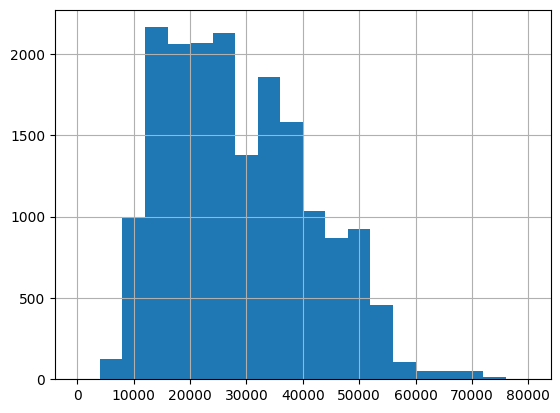

In [122]:
data.query('airports_nearest != -1')['airports_nearest'].hist(bins=20, range=(0,80000))

Удаленность квартир до ближайшего аэропорта составляет от 5000 до 75 000 метров. Среднее расстояние сновной доли квартир - 27 тыс. метров.

In [123]:
data.query('parks_nearest != -1')['parks_nearest'].median() # срез по удаленности квартир до ближайшего парка кроме -1

455.0

<AxesSubplot:>

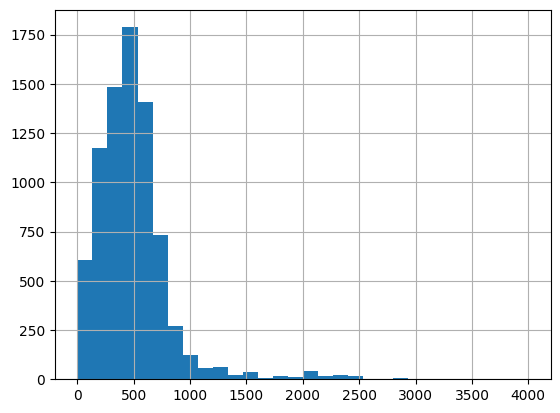

In [124]:
data.query('parks_nearest != -1')['parks_nearest'].hist(bins=30, range=(0,4000))

Удаленность квартир до ближайшего парка от 0 до 2500 м. Средняя 450 метров.

#### Исследование столбца `days_exposition`

Исследуем столбец `days_exposition`. Построим гистрограмму, найдем среднее и медиану количества дней продажи одной квартиры.

<AxesSubplot:>

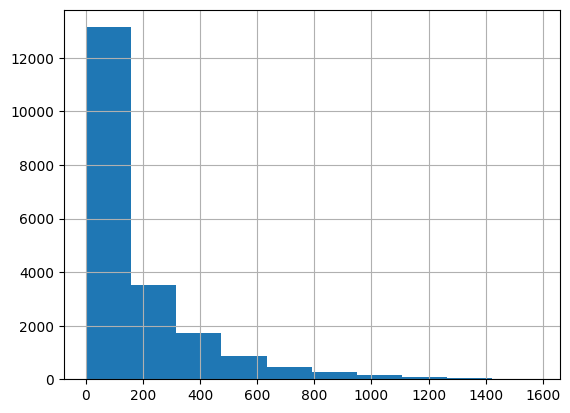

In [125]:
data['days_exposition'].hist()

In [126]:
data['days_exposition'].median() # медианное количество дней продажи квартиры

95.0

In [127]:
data['days_exposition'].mean() # среднее количетсво дней продажи квартиры

180.16718434156684

In [128]:
data['days_exposition'].describe()

count    20283.000000
mean       180.167184
std        218.885724
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медианное значение продажи квартиры в днях отличается от среденго значения почти в 2 раза, это свидетельствует о том, что сроки продаж каждой квартиры очень сильно отличаются, о чем говорит высокое значение стандартного отклонения. Быстрой продажей является среденее значение 0-95 дней. Хорошим показателем скорости продажи является 96-180 дней. И долгими продажами - свыше 180 дней.

#### Исследование факторов, влиящих на общую стоимость объекта

Исследуем какие факторы больше всего влияют на общую (полную) стоимость объекта. Построим графики, которые покажут зависимость цены от указанных ниже параметров:

        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);

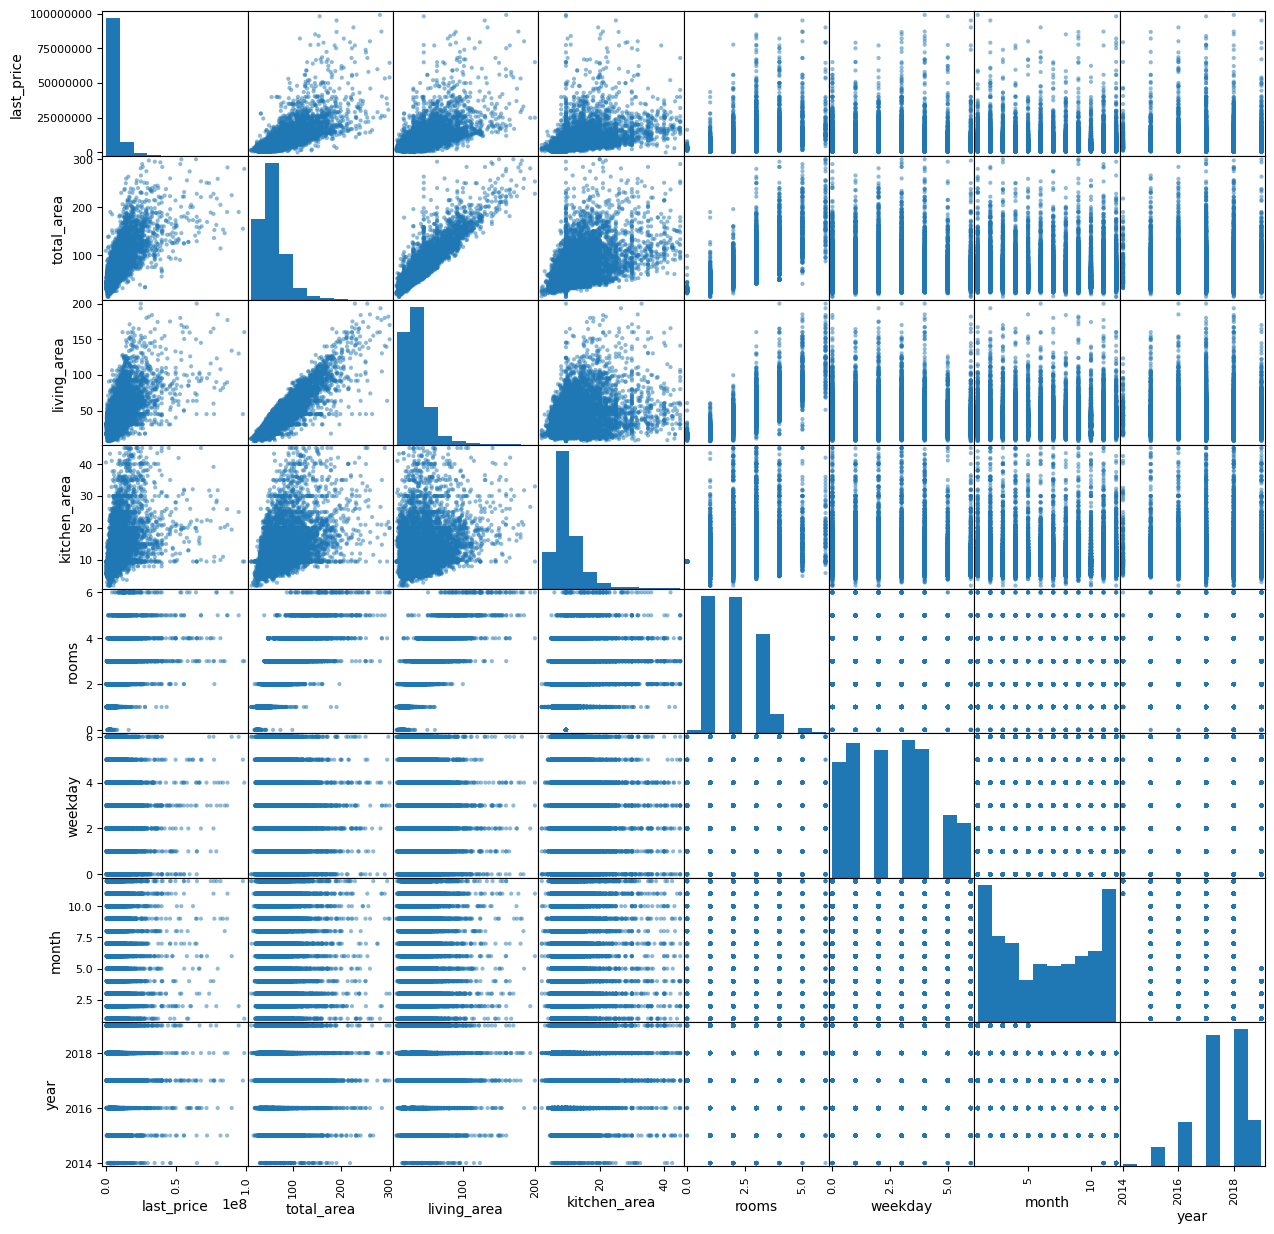

In [129]:
# матрица рассеяния
pd.plotting.scatter_matrix(data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'type_floor',
                                 'weekday', 'month', 'year']],  figsize=(15, 15));

In [130]:
# матрица зависимостей
data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'type_floor', 'weekday', 'month', 'year']].corr()

,last_price,total_area,living_area,kitchen_area,rooms,weekday,month,year
last_price,1.000000,0.750436,0.637112,0.513463,0.449390,-0.001928,0.006922,-0.049075
total_area,0.750436,1.000000,0.916468,0.549369,0.778162,-0.007881,0.006822,-0.085164
living_area,0.637112,0.916468,1.000000,0.344929,0.868138,-0.006834,-0.001155,-0.074996
kitchen_area,0.513463,0.549369,0.344929,1.000000,0.208988,-0.012955,0.008487,-0.053543
rooms,0.449390,0.778162,0.868138,0.208988,1.000000,-0.002767,-0.003137,-0.053545
weekday,-0.001928,-0.007881,-0.006834,-0.012955,-0.002767,1.000000,0.012142,-0.004795
month,0.006922,0.006822,-0.001155,0.008487,-0.003137,0.012142,1.000000,-0.270425
year,-0.049075,-0.085164,-0.074996,-0.053543,-0.053545,-0.004795,-0.270425,1.000000


- На стоимость объекта больше всего оказывает общая площадь. Наблюдается прямая зависимость: чем больше площадь, тем выше стоимость. Основная доля продаж на объекты до 200 кв. м. и стоимостью до 10 млн. руб.  
  На общую стоимость в большей степени оказывает третий фактор - живая площадь.

- Жилая площадь тоже оказывает влияние на цену: основная доля продаж приходится на объекты до 200 кв. м. и стоимостью до 10 млн. руб.
  На жилую площадь в большей степени оказывает стоимось третий фактор - общая площадь.

- Площадь кухни не сильно влияет на стоимость объекта, основная доля продаж с площадью до 50 кв. м.

- Количество комнат оказывает небольшое влияние на цену объекта. Это объясняется тем, оно зависит в большей степени от жилой площади.

- День, месяц, год никак не влияют на стоимось объекта за рассматриваемый период времени.

Исследуем зависимость средней цены квартиры от типа этажа (другой, первый, последний).

In [131]:
floor_data = data.pivot_table(index='type_floor', values='last_price', aggfunc='median')
floor_data

,last_price
type_floor,
другой,4800000.0
первый,3900000.0
последний,4280000.0


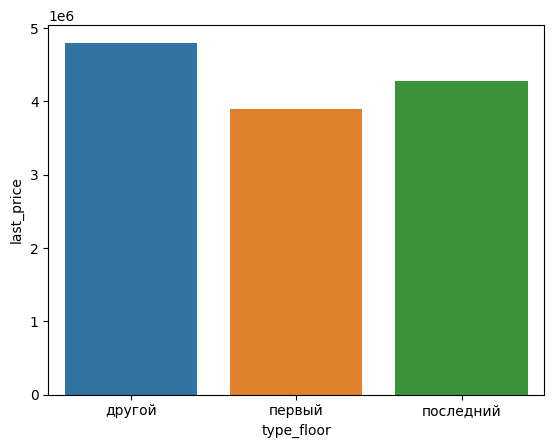

In [132]:
sns.barplot(x = floor_data.index, y = floor_data.last_price);

На первом этаже самые бюджетные квартиры, на последнем цены немного выше, чем на первом. На остальных этажах цены на квартиры в среднем выше, чем на первом и последнем.

Исследуем зависимость средней цены от даты размещения (день, месяц, год).

In [133]:
day_data = data.pivot_table(index='weekday', values='last_price', aggfunc='median')
day_data

,last_price
weekday,
0,4600000.0
1,4700000.0
2,4700000.0
3,4600000.0
4,4550000.0
5,4500000.0
6,4550000.0


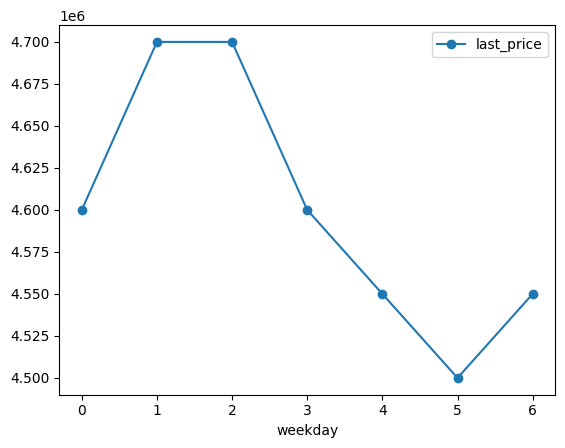

In [134]:
day_data.plot(style='o-');

Наблюдается волнообразная заисимость средней цены квартиры от дня размещения объявления: с пт по вт наблюдается ее рост (пн-вт пиковые значения), а с среды по пятницу - снижение. Средняя цена колеблется 4.5 - 4.7 млн. руб.

In [135]:
month_data = data.pivot_table(index='month', values='last_price', aggfunc='median')
month_data

,last_price
month,
1,4600000.0
2,4650000.0
3,4650000.0
4,4779507.0
5,4500000.0
6,4400000.0
7,4600000.0
8,4550000.0
9,4680000.0


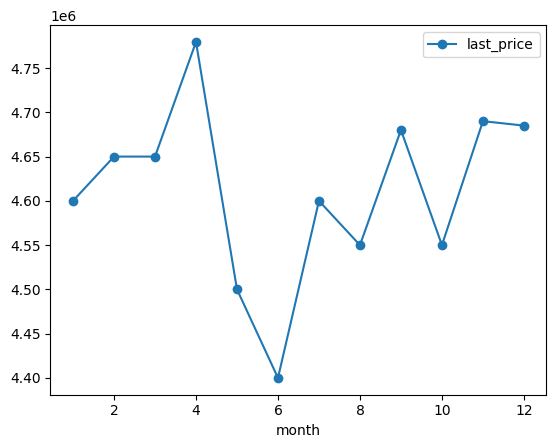

In [136]:
month_data.plot(style='o-');

С мая по июнь наблюдается спад средней цены квартитры, выставленной на продажу. С января по май наблюдается рост средней цены  в зависмости от месяца размещения. С июля по декабрь средняя цена неустойчива и колеблется от 4.5 до 4.7 млн. руб.

In [137]:
year_data = data.pivot_table(index='year', values='last_price', aggfunc='median')
year_data

,last_price
year,
2014,7640000.0
2015,5267500.0
2016,4500000.0
2017,4500000.0
2018,4550000.0
2019,5000000.0


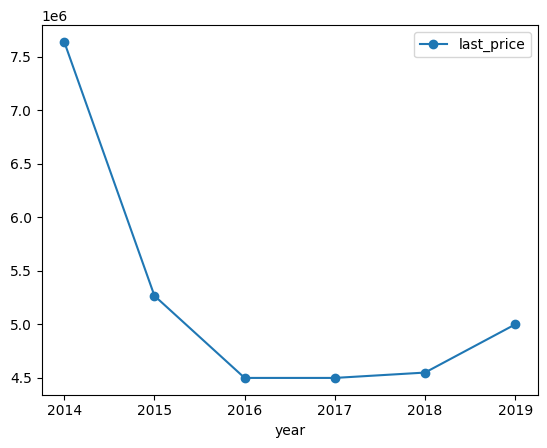

In [138]:
year_data.plot(style='o-');

С 2014 по 2016 наблюдался сильный спад средней цены квартиры, исследуем это отдельно ниже.

Исследуем изменение средних цен по годам с учетом других изменяющихся параметров: площадь и кол-во объявлений.

In [139]:
agg_year_data = data.pivot_table(index='year', values=['last_price', 'total_area'],
                                 aggfunc={'count', 'mean'}).style.format("{:,.2f}")
agg_year_data

Из агрегированной таблицы видно, что выборка за 2014 нерепрезентативная: в ней очень мало данных, чтобы ее анализировать. Спад цены на графике выше объясняется завышенными средней ценой и средней площадью. 2014 год стоит исключить из анализа по годам и учесть в дальнейшем. 
Вывод можно сделать такой: в 2015 году продавалась квартиры с бОльшей площадью дороже, чем в последующие до 2019. Начиная с 2016 года квартиры стали продавать с меньшей площадью с ценой ниже 2015 года. 

#### Расчет средней цены одного кв. м. в 10 населенных пунктов с наибольшим количеством объявлений

In [140]:
# в сводной талице посчитаем среднюю цену за кв.м. и количество повторений по каждому населенному пункту
df = data.pivot_table(index='locality_name', values='m2_price', aggfunc=[lambda x: int(x.mean()), 'count'])
df.columns = df.columns.droplevel(1) # избавляемся от мультииндекса

In [141]:
df.rename(columns = {'<lambda>':'m2_price', 'count':'count'}, inplace = True )

In [142]:
print(df.sort_values(by='count', ascending=False).head(10)) # топ-10 населенных пунктов по кол-ву объявлений

                 m2_price  count
locality_name                   
Санкт-Петербург  113078.0  15475
Мурино            85913.0    580
Кудрово           95337.0    470
Шушары            78655.0    439
Всеволожск        68720.0    395
Пушкин           102929.0    364
Колпино           75333.0    337
Парголово         90332.0    326
Гатчина           68746.0    307
Выборг            58190.0    234


In [143]:
# ТОП-10 населенных пунктов с наибольшим количеством объявлений с расчетом средней цены за 1 кв. м.
top10_data = df.sort_values(by='count', ascending=False).head(10)

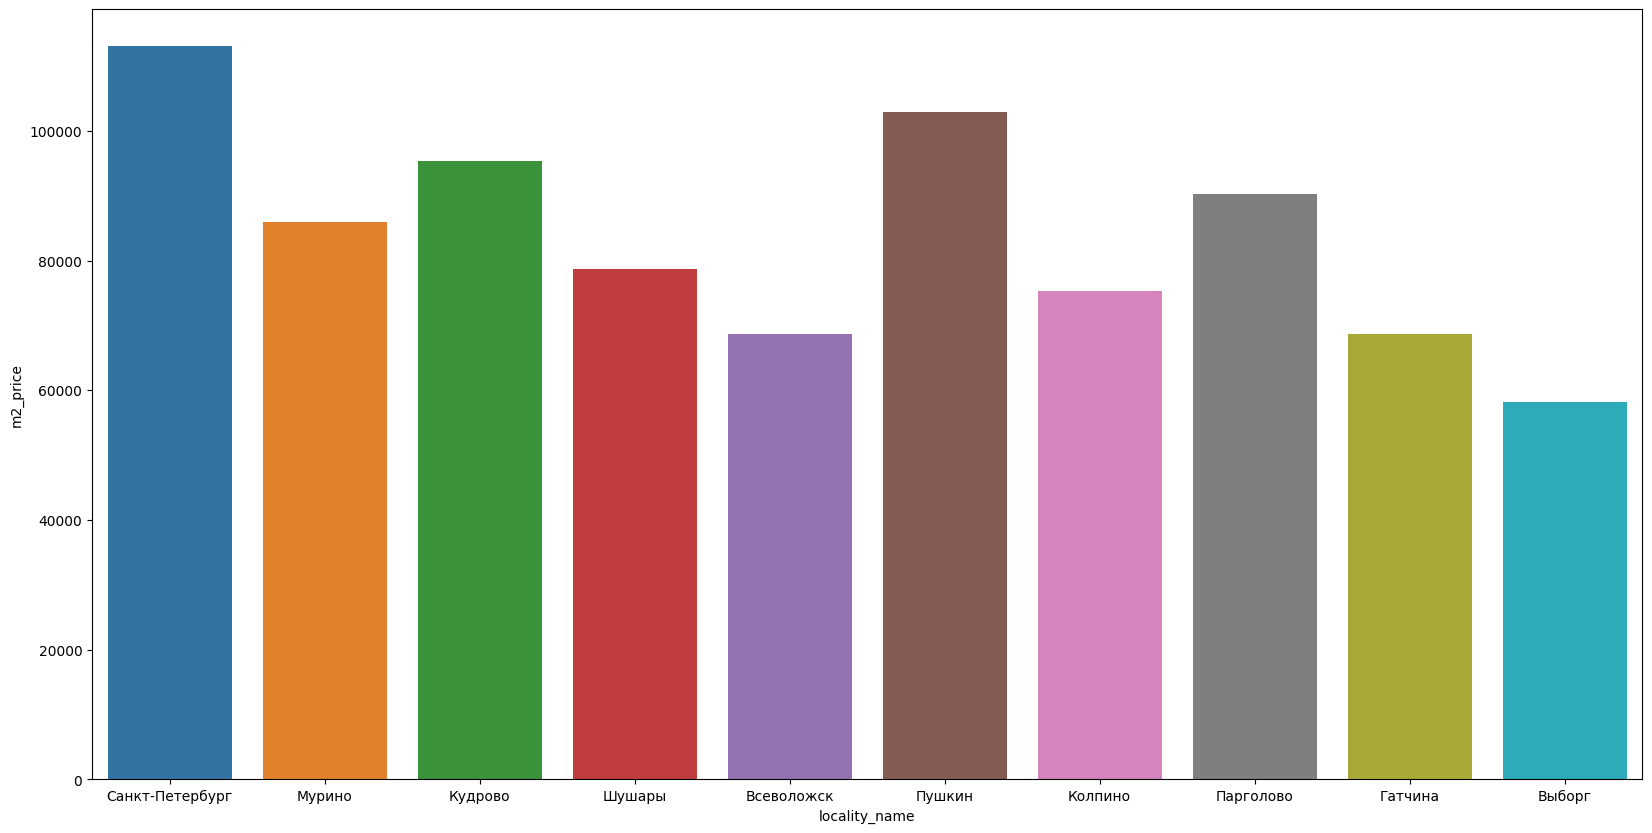

In [144]:
plt.rcParams['figure.figsize']=(20,10)
sns.barplot(x = top10_data.index, y = top10_data['m2_price']);

В Санкт-Петербурге объявлений на 2 с лишним порядка больше, чем от ближайшего конкурента в области. Средняя цена кв. м. недвижимости в Санкт-Петербурге остается самой высокой по сравнению с областью.

#### Расчет средней цены кв. м в зависимости от удаленности объекта от центра города

In [145]:
data_spb = data.loc[data['locality_name'] == 'Санкт-Петербург'] # отберем только Санкт-Петербург

#сгруппируем по километру среднюю цену на квартиру
data_spb_km = data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc = lambda x: round(x.mean()))

In [146]:
data_spb_km

,last_price
cityCenters_nearest_km,
-0.0,14667668.0
1.0,15276886.0
2.0,14168523.0
3.0,10416275.0
4.0,11124969.0
5.0,11950387.0
6.0,12354208.0
7.0,13340159.0
8.0,9061187.0


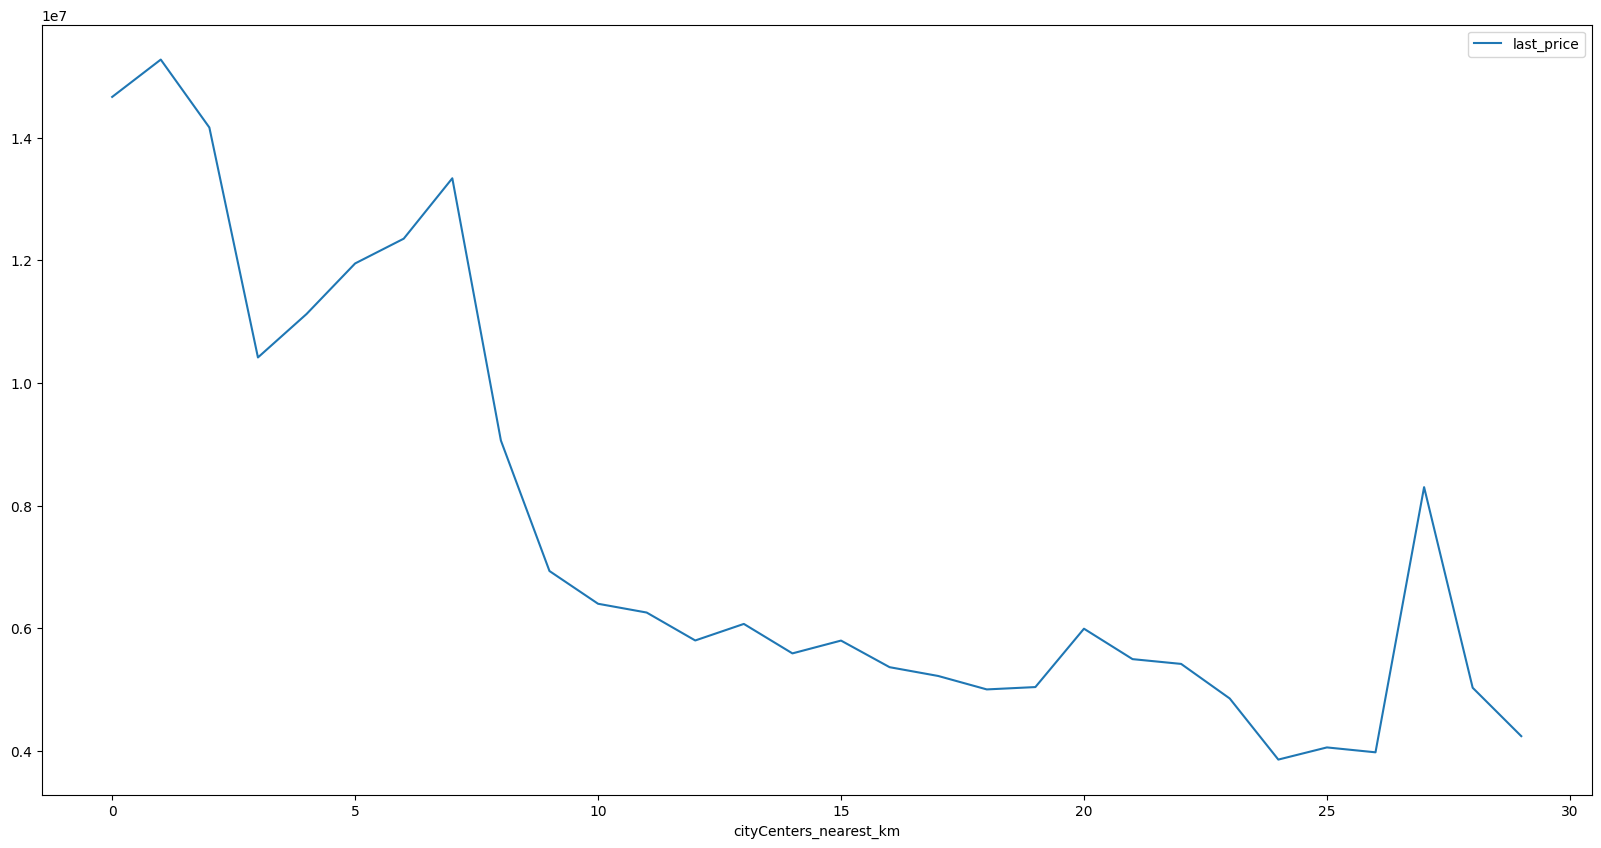

In [147]:
data_spb_km.plot(style='-');

Как видно на графике средняя цена кв. м. жилья в Санкт-Петербурге падает от центра в сторону области, но наблюдается выброс на 27 км и провал и пик на 3 и 7 км.

Исследуем их отдельно.

In [148]:
data_spb.loc[data_spb['cityCenters_nearest_km'] == 27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,weekday,month,year,type_floor,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,True,...,1496.0,0.0,-1.0,128.0,193919.0,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,True,...,-1.0,0.0,-1.0,178.0,70312.0,1,2,2018,последний,27.0


Выброс получился из-за того, что одна квартира очень дорогая, а вторая дешевая.

In [149]:
data_spb.loc[data_spb['cityCenters_nearest_km'] == 3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,weekday,month,year,type_floor,cityCenters_nearest_km
99,32,9600000.0,90.0,2017-09-26,4,2.65,5,67.0,2,True,...,-1.0,0.0,-1.0,104.0,106667.0,1,9,2017,другой,3.0
138,8,4800000.0,40.0,2017-11-18,2,2.65,3,29.0,2,True,...,-1.0,2.0,729.0,80.0,120000.0,5,11,2017,другой,3.0
154,1,8200000.0,80.0,2018-11-06,3,4.15,3,44.2,2,True,...,344.0,1.0,838.0,38.0,102500.0,1,11,2018,другой,3.0
179,5,14800000.0,108.7,2019-04-11,3,4.00,5,72.4,5,True,...,559.0,0.0,-1.0,NaN,136155.0,3,4,2019,последний,3.0
181,2,7900000.0,71.8,2017-08-23,3,3.00,5,38.7,1,True,...,-1.0,1.0,585.0,NaN,110028.0,2,8,2017,первый,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23449,4,6300000.0,52.6,2015-05-28,3,3.25,5,29.8,2,True,...,218.0,3.0,69.0,505.0,119772.0,3,5,2015,другой,3.0
5239,1,2645000.0,24.4,2018-12-10,1,3.33,6,12.2,2,True,...,-1.0,2.0,794.0,26.0,108402.0,0,12,2018,другой,3.0
16794,19,6200000.0,67.0,2016-04-04,2,3.78,4,55.0,4,False,...,186.0,1.0,341.0,408.0,92537.0,0,4,2016,последний,3.0
19372,6,7500000.0,62.2,2014-12-18,5,3.02,6,50.3,1,True,...,84.0,1.0,533.0,694.0,120579.0,3,12,2014,первый,3.0


In [150]:
data_spb.loc[data_spb['cityCenters_nearest_km'] == 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,weekday,month,year,type_floor,cityCenters_nearest_km
63,2,20000000.0,118.0,2018-09-11,3,3.00,9,68.0,7,True,...,648.0,1.0,779.0,37.0,169492.0,1,9,2018,другой,5.0
141,8,6500000.0,32.6,2019-02-27,1,2.65,5,18.5,5,True,...,-1.0,0.0,-1.0,NaN,199387.0,2,2,2019,последний,5.0
159,14,7050000.0,66.0,2017-09-04,3,3.00,4,37.8,4,False,...,-1.0,1.0,1013.0,98.0,106818.0,0,9,2017,последний,5.0
219,12,7700000.0,58.7,2017-12-12,1,2.65,7,17.0,3,True,...,239.0,0.0,-1.0,136.0,131175.0,1,12,2017,другой,5.0
262,14,37500000.0,158.0,2019-01-24,4,2.65,12,88.0,4,True,...,-1.0,2.0,840.0,NaN,237342.0,3,1,2019,другой,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16606,8,6695000.0,58.0,2018-10-11,2,2.65,6,43.0,6,True,...,231.0,3.0,537.0,42.0,115431.0,3,10,2018,последний,5.0
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5,10.6,2,False,...,644.0,0.0,-1.0,24.0,142308.0,0,3,2019,другой,5.0
20197,11,7500000.0,48.0,2016-12-19,2,3.95,5,18.0,3,False,...,463.0,0.0,-1.0,845.0,156250.0,0,12,2016,другой,5.0
20256,5,13351000.0,102.7,2018-07-03,6,3.40,4,85.4,1,True,...,519.0,0.0,-1.0,229.0,130000.0,1,7,2018,первый,5.0


Чтобы понять почему график изменился с 3 по 7 км, проанализируем его параметры на одном из концов и посередине, т.е. на 3 и 5 км. На цену квартиры влияет этаж, на котором она расположена. Сделем агрегированные таблицы для каждого из этих киллометров.

In [151]:
data_spb.loc[data_spb['cityCenters_nearest_km'] == 3].pivot_table(index='type_floor', values='last_price', aggfunc='count')

,last_price
type_floor,
другой,207
первый,54
последний,75


In [152]:
data_spb.loc[data_spb['cityCenters_nearest_km'] == 5].pivot_table(index='type_floor', values='last_price', aggfunc='count')

,last_price
type_floor,
другой,665
первый,78
последний,131


Посчитаем их соотношение в долях к общему числу квартир на этих километрах.

In [153]:
spb_km_3 = (data_spb.loc[data_spb['cityCenters_nearest_km'] == 3] 
        .pivot_table(index='type_floor', values='last_price', aggfunc='count')
       )

In [154]:
spb_km_3['percent'] = round(spb_km_3['last_price'] * 100 / spb_km_3['last_price'].sum())

In [155]:
spb_km_3

,last_price,percent
type_floor,,
другой,207,62.0
первый,54,16.0
последний,75,22.0


In [156]:
spb_km_5 = (data_spb.loc[data_spb['cityCenters_nearest_km'] == 5] 
        .pivot_table(index='type_floor', values='last_price', aggfunc='count')
       )

In [157]:
spb_km_5['percent'] = round(spb_km_5['last_price'] * 100 / spb_km_5['last_price'].sum())

In [158]:
spb_km_5

,last_price,percent
type_floor,,
другой,665,76.0
первый,78,9.0
последний,131,15.0


Из соотношения продаж первых/последних этажей с другими этажами видно, что доля последних возрастает в общем количестве всех продаваемых квартир. Это значит, что они будут "тянуть" вверх за собой общую среднюю цену всех квартир.

### Общий вывод

Исследование проводилось по Санкт-Петебургу и его области. На основе объявлений о продаже недвижимости были исследованы их параметры и рассчитана средняя цена за кв.м., проведен анализ факторов, влияющих на нее.

Усредненные данные по всем проданным квартирам:
- количество комнат - 2
- общая площадь - 51 кв.м
- жилая площадь - 30 кв.м
- площадь кухни - 9.5 кв.м.
- высота потолка - 2.65 м.
- этаж квартиры - 4
- цена продажи 4.5 млн. руб
- период выставления на продажу - в конце рабочей недели летом

Количество квартир на первом и последних этажаж в сумме в 2.6 раза меньше, чем всех остальных вместе взятых.
Основную долю жилого сектора составляют 5 и 9 этажные дома. В осенне-зимний сезон продажи падают, наблюдается только всплеск в феврале. В летне-весенний сезон продажи увеличиваются, наблюдается провал только в мае. Удаленность типичной квартиры от центра - 13 км, до ближайшего аэропорта - 27 км, до ближайшего парка - 450 м.

Быстрой продажей является срок 0-95 дней. Хорошим показателем скорости продажи является 96-180 дней. И долгими продажами свыше 180 дней.

- На стоимость объекта больше всего оказывает влияние общая площадь. Наблюдается прямая зависимость: чем больше площадь, тем выше стоимость. Основная доля продаж на объекты до 200 кв. м. и стоимостью до 10 млн. руб. На общую стоимость в большей степени оказывает третий фактор - жилая площадь.

- Жилая площадь тоже оказывает влияние на цену: основная доля продаж приходится на объекты до 200 кв. м. и стоимостью до 10 млн. руб. На жилую площадь в большей степени оказывает третий фактор - общая площадь.

- Площадь кухни не сильно влияет на стоимость объекта.

- Количество комнат оказывает небольшое влияние на цену объекта. Это объясняется тем, оно зависит в большей степени от жилой площади.

- С пятницы по вторник наблюдается ее рост (пн-вт пиковые значения), а с среды по пятницу - снижение. С мая по июнь блюдается рост средней цены, а с июля по декабрь она колеблется вверх-вниз. В 2015 году продавались квартиры с бОльшей площадью дороже, чем в последующие до 2019. Начиная с 2016 года квартиры стали продавать с меньшей площадью с ценой ниже 2015 года. 2014 год исключен из анализа, т.к. собрано мало данных.

В Санкт-Петербурге объявлений на 2 с лишним порядка больше, чем от ближайшего конкурента в области. Средняя цена кв. м. недвижимости в Санкт-Петербурге остается самой высокой по сравнению с областью и разница может достигать 10-кратного размера в некоторых населенных пунктах.

Средняя цена кв. м. жилья в Санкт-Петербурге падает от цетра к области, наблюдается рост средней цены только с 3 по 7 км, это объясняется тем, что на этом промежутке доля бюджетных квартир на первом/последних этажах снижается. На 27 км к выбросу привело то, что продается 2 квартиры - одна очень дешевая, вторая очень дорогая.